In [4]:
from run_gom_mp import *
import pandas as pd
import xarray as xr
from datetime import timedelta as delta

from parcels import plotTrajectoriesFile

# RUN SIMULATION
%run -i gom_mp_kernels.py
%run -i run_gom_mp_backwards.py

#fieldset, pset = run_gom_mp_backwards('testing_output/b_test.zarr', disp = True, stokes = True, diff = 0.1)

INFO: Compiled ArrayNurdleDisplaceAdvectionRK4SmagDiffSetDisplacement ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib98d69811c25c4dbd94c4130eb2e552c2_0.dll
INFO: Output files are stored in testing_output/b_test.zarr.
 21%|██▏       | 6753599.999999747/31536000.0 [08:44<1:12:37, 5686.95it/s] 

Particle [5575389] lost !! (-86.9622 18.2195 0 8.51796e+07)
Particle [5575646] lost !! (-86.5329 18.2149 0 8.5176e+07)
Particle [5581394] lost !! (-86.4838 18.2159 0 8.5176e+07)


 21%|██▏       | 6768000.000000253/31536000.0 [08:45<39:15, 10514.52it/s] 

Particle [5581273] lost !! (-86.6973 18.2072 0 8.51616e+07)
Particle [5581524] lost !! (-86.8375 18.2062 0 8.51616e+07)


 22%|██▏       | 6789600.000000253/31536000.0 [08:47<33:17, 12387.04it/s]

Particle [5575203] lost !! (-86.4536 18.2125 0 8.51436e+07)


 22%|██▏       | 6796799.999999747/31536000.0 [08:47<34:44, 11868.33it/s]

Particle [5575647] lost !! (-86.8852 18.219 0 8.51364e+07)


 22%|██▏       | 6804000.0/31536000.0 [08:48<34:52, 11818.58it/s]        

Particle [5575156] lost !! (-86.9787 18.2144 0 8.51292e+07)


 22%|██▏       | 6811200.000000253/31536000.0 [08:48<34:37, 11902.13it/s]

Particle [5575407] lost !! (-86.1928 18.2149 0 8.5122e+07)


 22%|██▏       | 6822000.000000253/31536000.0 [08:49<33:28, 12302.78it/s]

Particle [5575531] lost !! (-86.0232 18.2093 0 8.51112e+07)


 22%|██▏       | 6829199.999999747/31536000.0 [08:53<1:37:30, 4223.12it/s]

Particle [5580312] lost !! (-87.4063 18.2215 0 8.51004e+07)
Particle [5581633] lost !! (-86.0681 18.21 0 8.51004e+07)


 22%|██▏       | 6879600.0/31536000.0 [08:56<26:03, 15773.74it/s]         

Particle [5575357] lost !! (-86.9951 18.2249 0 8.505e+07)
Particle [5580684] lost !! (-86.8128 18.225 0 8.505e+07)


 22%|██▏       | 6908400.000000253/31536000.0 [08:58<31:06, 13192.08it/s]

Particle [5575055] lost !! (-86.6721 18.2251 0 8.50248e+07)


 22%|██▏       | 6915599.999999747/31536000.0 [09:01<1:37:31, 4207.74it/s]

Particle [5575747] lost !! (-86.7976 18.2146 0 8.5014e+07)
Particle [5581621] lost !! (-86.4391 18.2168 0 8.5014e+07)


 22%|██▏       | 6922800.0/31536000.0 [09:02<1:11:36, 5729.11it/s]        

Particle [5575215] lost !! (-86.9281 18.2164 0 8.50104e+07)


 22%|██▏       | 6955200.0/31536000.0 [09:04<32:01, 12789.97it/s]        

Particle [5581293] lost !! (-86.8472 18.222 0 8.4978e+07)


 22%|██▏       | 6962400.000000253/31536000.0 [09:05<32:53, 12452.09it/s]

Particle [5575180] lost !! (-86.5455 18.2143 0 8.49708e+07)


 22%|██▏       | 6966000.0/31536000.0 [09:05<36:09, 11324.42it/s]        

Particle [5575301] lost !! (-86.4691 18.2125 0 8.49672e+07)


 22%|██▏       | 6969599.999999747/31536000.0 [09:06<37:50, 10821.36it/s]

Particle [5580515] lost !! (-84.4423 18.2133 0 8.49636e+07)


 22%|██▏       | 6973200.000000253/31536000.0 [09:06<39:22, 10398.92it/s]

Particle [5581571] lost !! (-84.57 18.2178 0 8.496e+07)


 22%|██▏       | 6976800.0/31536000.0 [09:07<40:13, 10174.02it/s]        

Particle [5580646] lost !! (-86.7945 18.2284 0 8.49564e+07)


 22%|██▏       | 6980399.999999747/31536000.0 [09:07<40:19, 10147.10it/s]

Particle [5575401] lost !! (-86.4708 18.2206 0 8.49528e+07)
Particle [5575205] lost !! (-86.4392 18.2221 0 8.49492e+07)
Particle [5575491] lost !! (-84.4576 18.2163 0 8.49492e+07)


 22%|██▏       | 6987600.0/31536000.0 [09:08<39:18, 10406.54it/s]        

Particle [5580431] lost !! (-86.6246 18.2074 0 8.4942e+07)
Particle [5580535] lost !! (-84.6157 18.2181 0 8.4942e+07)


 22%|██▏       | 6991199.999999747/31536000.0 [09:08<42:14, 9682.91it/s]

Particle [5575432] lost !! (-86.3783 18.2159 0 8.49384e+07)
Particle [5580912] lost !! (-86.52 18.2169 0 8.49384e+07)
Particle [5581410] lost !! (-86.1888 18.2171 0 8.49384e+07)


 22%|██▏       | 6994800.000000253/31536000.0 [09:09<46:25, 8811.68it/s]

Particle [5575196] lost !! (-84.5067 18.213 0 8.49348e+07)


 22%|██▏       | 6998400.0/31536000.0 [09:12<2:27:28, 2773.06it/s]      

Particle [5575564] lost !! (-84.551 18.2206 0 8.49312e+07)
Particle [5575723] lost !! (-86.3181 18.2122 0 8.49312e+07)


 22%|██▏       | 7005600.000000253/31536000.0 [09:13<1:39:34, 4105.82it/s]

Particle [5575376] lost !! (-84.5897 18.213 0 8.49276e+07)


 22%|██▏       | 7009200.0/31536000.0 [09:13<1:23:33, 4891.96it/s]        

Particle [5575163] lost !! (-86.4506 18.2087 0 8.4924e+07)


 22%|██▏       | 7016400.000000253/31536000.0 [09:14<58:33, 6977.99it/s]  

Particle [5575191] lost !! (-86.3813 18.2176 0 8.49168e+07)


 22%|██▏       | 7023599.999999747/31536000.0 [09:14<41:46, 9780.21it/s]

Particle [5575167] lost !! (-86.2767 18.2132 0 8.4906e+07)
Particle [5581575] lost !! (-86.1242 18.2141 0 8.4906e+07)


 22%|██▏       | 7034399.999999747/31536000.0 [09:15<39:41, 10289.14it/s]

Particle [5580468] lost !! (-84.4858 18.2199 0 8.48988e+07)


 22%|██▏       | 7038000.000000253/31536000.0 [09:16<40:13, 10149.82it/s]

Particle [5580489] lost !! (-86.301 18.216 0 8.48952e+07)
Particle [5575406] lost !! (-84.4895 18.2174 0 8.48916e+07)
Particle [5575429] lost !! (-86.2285 18.2156 0 8.48916e+07)


 22%|██▏       | 7048800.000000253/31536000.0 [09:17<38:53, 10492.61it/s]

Particle [5581608] lost !! (-84.3219 18.2188 0 8.48844e+07)


 23%|██▎       | 7102800.000000253/31536000.0 [09:23<46:58, 8670.31it/s]  

Particle [5575352] lost !! (-86.6509 18.2176 0 8.48304e+07)


 23%|██▎       | 7149600.0/31536000.0 [09:26<30:06, 13495.84it/s]        

Particle [5581019] lost !! (-86.2065 18.2109 0 8.47836e+07)


 23%|██▎       | 7200000.000000253/31536000.0 [09:33<35:16, 11500.32it/s] 

Particle [5575361] lost !! (-86.0016 18.2089 0 8.47332e+07)


 23%|██▎       | 7236000.0/31536000.0 [09:35<30:11, 13410.99it/s]        

Particle [5580393] lost !! (-85.699 18.2111 0 8.46972e+07)


 23%|██▎       | 7304399.999999747/31536000.0 [09:42<30:11, 13375.39it/s] 

Particle [5575394] lost !! (-84.0912 18.213 0 8.46288e+07)


 23%|██▎       | 7308000.000000253/31536000.0 [09:43<32:57, 12251.49it/s]

Particle [5575190] lost !! (-84.1935 18.2176 0 8.46252e+07)


 23%|██▎       | 7311600.0/31536000.0 [09:43<35:17, 11440.24it/s]        

Particle [5581401] lost !! (-84.1853 18.2145 0 8.46216e+07)


 23%|██▎       | 7322400.0/31536000.0 [09:44<34:30, 11694.01it/s]        

Particle [5575528] lost !! (-86.8896 18.2233 0 8.46108e+07)


 23%|██▎       | 7336799.999999747/31536000.0 [09:45<32:07, 12554.00it/s]

Particle [5580877] lost !! (-83.8155 18.2121 0 8.45964e+07)


 23%|██▎       | 7358399.999999747/31536000.0 [09:50<55:22, 7276.46it/s]  

Particle [5575234] lost !! (-86.3262 18.2105 0 8.45748e+07)


 23%|██▎       | 7365600.0/31536000.0 [09:50<46:25, 8678.10it/s]        

Particle [5575431] lost !! (-86.8226 18.2261 0 8.45676e+07)


 24%|██▍       | 7513200.000000253/31536000.0 [10:06<30:01, 13334.95it/s] 

Particle [5581612] lost !! (-84.6916 18.21 0 8.442e+07)


 24%|██▍       | 7585199.999999747/31536000.0 [10:22<42:21, 9424.06it/s]  

Particle [5580296] lost !! (-86.5312 18.2152 0 8.4348e+07)


 24%|██▍       | 7653600.000000253/31536000.0 [10:36<37:57, 10485.42it/s] 

Particle [5575438] lost !! (-83.9941 18.2159 0 8.4276e+07)


 25%|██▌       | 8027999.999999747/31536000.0 [11:20<33:33, 11673.14it/s] 

Particle [5575195] lost !! (-86.6645 18.2164 0 8.39052e+07)


 26%|██▌       | 8107200.000000253/31536000.0 [11:30<32:55, 11857.55it/s] 

Particle [5575152] lost !! (-86.8124 18.2147 0 8.3826e+07)


 26%|██▌       | 8197200.0/31536000.0 [11:43<33:03, 11765.55it/s]         

Particle [5580445] lost !! (-86.7567 18.2172 0 8.3736e+07)


 26%|██▌       | 8204400.000000253/31536000.0 [11:44<35:33, 10937.98it/s]

Particle [5575102] lost !! (-86.7865 18.2188 0 8.37288e+07)


 26%|██▌       | 8247600.000000253/31536000.0 [11:51<35:27, 10948.37it/s] 

Particle [5580932] lost !! (-86.8372 18.2193 0 8.36856e+07)


 26%|██▌       | 8258400.000000253/31536000.0 [11:52<35:44, 10856.54it/s]

Particle [5580720] lost !! (-86.847 18.2134 0 8.36748e+07)


 26%|██▋       | 8301600.000000253/31536000.0 [11:59<1:32:21, 4192.95it/s]

Particle [5575131] lost !! (-86.57 18.2164 0 8.36316e+07)


 26%|██▋       | 8334000.000000253/31536000.0 [12:02<35:11, 10990.21it/s] 

Particle [5580345] lost !! (-86.7542 18.2121 0 8.35992e+07)


 26%|██▋       | 8344800.000000253/31536000.0 [12:03<35:44, 10814.33it/s]

Particle [5575056] lost !! (-86.3987 18.2202 0 8.35884e+07)


 26%|██▋       | 8348400.0/31536000.0 [12:03<38:29, 10041.83it/s]        

Particle [5575128] lost !! (-86.457 18.2148 0 8.35848e+07)


 27%|██▋       | 8409600.000000253/31536000.0 [12:11<39:39, 9718.93it/s]  

Particle [5575428] lost !! (-86.7517 18.218 0 8.35236e+07)


 27%|██▋       | 8449199.999999747/31536000.0 [12:15<33:02, 11644.23it/s]

Particle [5575216] lost !! (-86.7889 18.2214 0 8.3484e+07)


 27%|██▋       | 8492399.999999747/31536000.0 [12:22<42:23, 9059.45it/s]  

Particle [5575245] lost !! (-86.6424 18.2207 0 8.34408e+07)


 27%|██▋       | 8564400.0/31536000.0 [12:31<1:09:59, 5470.18it/s]        

Particle [5581545] lost !! (-86.5905 18.2253 0 8.33652e+07)


 27%|██▋       | 8668800.000000253/31536000.0 [12:43<38:13, 9968.55it/s]  

Particle [5575309] lost !! (-86.3876 18.2161 0 8.32644e+07)
Particle [5581277] lost !! (-86.5647 18.2134 0 8.32608e+07)


 28%|██▊       | 8704800.0/31536000.0 [12:46<28:52, 13177.72it/s]        

Particle [5580651] lost !! (-86.4387 18.2134 0 8.32248e+07)
Particle [5581522] lost !! (-86.2711 18.2118 0 8.32248e+07)


 28%|██▊       | 8715600.0/31536000.0 [12:47<35:53, 10597.01it/s]        

Particle [5575349] lost !! (-86.3727 18.2153 0 8.32176e+07)


 28%|██▊       | 8722800.000000253/31536000.0 [12:47<30:54, 12301.94it/s]

Particle [5575383] lost !! (-86.3778 18.2175 0 8.32068e+07)


 28%|██▊       | 8837999.999999747/31536000.0 [13:03<42:12, 8962.18it/s]  

Particle [5575276] lost !! (-86.1392 18.2175 0 8.30952e+07)


 28%|██▊       | 8848799.999999747/31536000.0 [13:04<36:19, 10411.24it/s]

Particle [5574665] lost !! (-85.9188 18.2142 0 8.30844e+07)


 28%|██▊       | 8910000.0/31536000.0 [13:13<1:19:19, 4753.68it/s]        

Particle [5580590] lost !! (-85.5347 18.2114 0 8.30232e+07)


 29%|██▊       | 9043199.999999747/31536000.0 [13:27<27:44, 13517.24it/s] 

Particle [5575118] lost !! (-85.894 18.2172 0 8.289e+07)


 29%|██▉       | 9068400.000000253/31536000.0 [13:28<24:19, 15389.70it/s]

Particle [5575187] lost !! (-85.6978 18.2186 0 8.28612e+07)


 29%|██▉       | 9075599.999999747/31536000.0 [13:33<1:51:58, 3343.31it/s]

Particle [5574781] lost !! (-85.78 18.2104 0 8.28576e+07)


 29%|██▉       | 9097199.999999747/31536000.0 [13:34<39:00, 9588.37it/s]  

Particle [5575062] lost !! (-85.8093 18.2178 0 8.2836e+07)


 29%|██▉       | 9140399.999999747/31536000.0 [13:37<30:42, 12155.71it/s]

Particle [5575557] lost !! (-85.8513 18.2266 0 8.27928e+07)


 29%|██▉       | 9169200.0/31536000.0 [13:43<1:09:19, 5377.57it/s]        

Particle [5575030] lost !! (-85.9458 18.2204 0 8.2764e+07)


 29%|██▉       | 9176400.000000253/31536000.0 [13:44<49:35, 7514.85it/s]

Particle [5575124] lost !! (-86.1475 18.2139 0 8.27568e+07)


 29%|██▉       | 9205199.999999747/31536000.0 [13:46<30:06, 12358.72it/s]

Particle [5575120] lost !! (-86.0355 18.2201 0 8.2728e+07)


 29%|██▉       | 9234000.0/31536000.0 [13:48<28:57, 12836.79it/s]        

Particle [5575049] lost !! (-85.7877 18.2189 0 8.26992e+07)


 29%|██▉       | 9237599.999999747/31536000.0 [13:48<31:09, 11925.92it/s]

Particle [5575073] lost !! (-86.1893 18.2106 0 8.26956e+07)


 30%|██▉       | 9334799.999999747/31536000.0 [14:05<1:48:03, 3424.50it/s]

Particle [5575295] lost !! (-85.6245 18.2196 0 8.25984e+07)


 30%|██▉       | 9345599.999999747/31536000.0 [14:06<58:31, 6318.96it/s]  

Particle [5575291] lost !! (-85.6605 18.2162 0 8.25876e+07)


 30%|██▉       | 9352800.0/31536000.0 [14:07<45:33, 8115.55it/s]        

Particle [5575097] lost !! (-85.5537 18.2154 0 8.25804e+07)


 30%|██▉       | 9424800.000000253/31536000.0 [14:19<2:15:24, 2721.50it/s]

Particle [5575165] lost !! (-85.494 18.2156 0 8.25084e+07)


 30%|██▉       | 9431999.999999747/31536000.0 [14:20<1:24:57, 4336.04it/s]

Particle [5574486] lost !! (-94.5013 18.2092 0 8.25012e+07)


 30%|███       | 9496799.999999747/31536000.0 [14:25<30:10, 12174.83it/s] 

Particle [5580281] lost !! (-87.5334 18.2134 0 8.24364e+07)


 30%|███       | 9532800.000000253/31536000.0 [14:31<36:27, 10057.21it/s] 

Particle [5575075] lost !! (-84.0018 18.2161 0 8.24004e+07)


 30%|███       | 9576000.000000253/31536000.0 [14:34<30:01, 12186.47it/s]

Particle [5575088] lost !! (-86.3719 18.2166 0 8.23572e+07)


 30%|███       | 9597600.000000253/31536000.0 [14:40<1:28:01, 4154.18it/s]

Particle [5575080] lost !! (-87.1033 18.2109 0 8.23356e+07)


 31%|███       | 9626399.999999747/31536000.0 [14:42<34:44, 10510.53it/s] 

Particle [5575040] lost !! (-83.9269 18.2121 0 8.23068e+07)


 31%|███       | 9637199.999999747/31536000.0 [14:43<33:47, 10799.01it/s]

Particle [5580297] lost !! (-86.7963 18.2095 0 8.2296e+07)


 31%|███       | 9655200.0/31536000.0 [14:44<30:59, 11769.50it/s]        

Particle [5574677] lost !! (-86.8498 18.2099 0 8.2278e+07)


 31%|███       | 9673200.000000253/31536000.0 [14:46<26:43, 13633.33it/s]

Particle [5575931] lost !! (-86.4999 18.2109 0 8.22564e+07)


 31%|███       | 9687600.0/31536000.0 [14:51<1:15:32, 4820.69it/s]        

Particle [5575004] lost !! (-86.1549 18.209 0 8.22456e+07)


 31%|███       | 9716400.000000253/31536000.0 [14:53<32:31, 11179.58it/s] 

Particle [5581578] lost !! (-85.1067 18.2177 0 8.22168e+07)


 31%|███       | 9734399.999999747/31536000.0 [14:55<31:04, 11694.61it/s]

Particle [5574895] lost !! (-86.3969 18.2164 0 8.21988e+07)


 31%|███       | 9777599.999999747/31536000.0 [15:02<58:40, 6180.76it/s]  

Particle [5575019] lost !! (-84.5876 18.2167 0 8.21556e+07)
Particle [5574953] lost !! (-85.5712 18.2119 0 8.2152e+07)
Particle [5575139] lost !! (-85.6722 18.2108 0 8.2152e+07)


 31%|███       | 9795600.0/31536000.0 [15:03<38:20, 9449.58it/s]        

Particle [5575013] lost !! (-85.2037 18.2132 0 8.21376e+07)


 31%|███       | 9809999.999999747/31536000.0 [15:05<32:42, 11071.65it/s]

Particle [5574923] lost !! (-85.1512 18.2181 0 8.21232e+07)


 31%|███       | 9817200.0/31536000.0 [15:05<33:37, 10766.45it/s]        

Particle [5574970] lost !! (-85.2713 18.213 0 8.2116e+07)


 31%|███       | 9820799.999999747/31536000.0 [15:06<36:04, 10033.37it/s]

Particle [5574996] lost !! (-85.5478 18.2102 0 8.21124e+07)


 31%|███       | 9824400.000000253/31536000.0 [15:06<37:31, 9644.68it/s] 

Particle [5574977] lost !! (-85.4435 18.2105 0 8.21088e+07)


 31%|███       | 9828000.0/31536000.0 [15:07<39:34, 9141.26it/s]        

Particle [5574671] lost !! (-84.6684 18.2148 0 8.21052e+07)
Particle [5574971] lost !! (-85.2732 18.2158 0 8.21016e+07)
Particle [5575001] lost !! (-85.2685 18.2164 0 8.21016e+07)


 31%|███       | 9835200.000000253/31536000.0 [15:07<37:10, 9730.33it/s]

Particle [5573425] lost !! (-85.4542 18.2156 0 8.20944e+07)
Particle [5574990] lost !! (-85.3969 18.2163 0 8.20944e+07)


 31%|███       | 9842399.999999747/31536000.0 [15:08<40:59, 8821.26it/s]

Particle [5575838] lost !! (-85.0061 18.216 0 8.20908e+07)


 31%|███       | 9846000.000000253/31536000.0 [15:09<40:46, 8865.59it/s]

Particle [5574891] lost !! (-85.2592 18.2153 0 8.20872e+07)
Particle [5574987] lost !! (-85.3495 18.2147 0 8.20836e+07)


 31%|███▏      | 9871200.0/31536000.0 [15:15<46:16, 7802.91it/s]          

Particle [5574921] lost !! (-85.0423 18.2206 0 8.2062e+07)


 31%|███▏      | 9900000.000000253/31536000.0 [15:17<26:50, 13431.35it/s]

Particle [5574790] lost !! (-85.9668 18.2113 0 8.20296e+07)
Particle [5575125] lost !! (-84.5038 18.2165 0 8.20296e+07)


 31%|███▏      | 9914400.0/31536000.0 [15:18<34:07, 10562.00it/s]        

Particle [5581324] lost !! (-85.3939 18.2168 0 8.20188e+07)


 31%|███▏      | 9925200.0/31536000.0 [15:19<29:37, 12160.38it/s]        

Particle [5574498] lost !! (-93.9699 18.2378 0 8.20044e+07)
Particle [5574886] lost !! (-84.722 18.2092 0 8.20044e+07)


 31%|███▏      | 9932400.000000253/31536000.0 [15:20<37:31, 9594.89it/s]

Particle [5574968] lost !! (-85.2262 18.2142 0 8.20008e+07)
Particle [5574897] lost !! (-85.2412 18.2176 0 8.19972e+07)
Particle [5575837] lost !! (-85.4554 18.211 0 8.19972e+07)


 32%|███▏      | 9939599.999999747/31536000.0 [15:25<2:06:04, 2854.80it/s]

Particle [5581677] lost !! (-84.9428 18.218 0 8.19936e+07)
Particle [5575010] lost !! (-85.2974 18.2169 0 8.199e+07)
Particle [5580283] lost !! (-87.237 18.2151 0 8.199e+07)


 32%|███▏      | 9946800.0/31536000.0 [15:26<1:26:11, 4174.46it/s]        

Particle [5573516] lost !! (-85.1068 18.2165 0 8.19864e+07)


 32%|███▏      | 9957600.0/31536000.0 [15:27<51:09, 7029.70it/s]          

Particle [5581360] lost !! (-84.5538 18.2142 0 8.19756e+07)


 32%|███▏      | 9979200.0/31536000.0 [15:29<33:45, 10644.64it/s]        

Particle [5573526] lost !! (-85.0573 18.2111 0 8.1954e+07)


 32%|███▏      | 9982799.999999747/31536000.0 [15:29<36:22, 9873.21it/s]

Particle [5574635] lost !! (-85.2009 18.2157 0 8.19504e+07)


 32%|███▏      | 9986400.000000253/31536000.0 [15:29<38:33, 9315.86it/s]

Particle [5575063] lost !! (-85.3196 18.2171 0 8.19468e+07)


 32%|███▏      | 9993599.999999747/31536000.0 [15:30<36:24, 9859.83it/s]

Particle [5581356] lost !! (-85.4786 18.2124 0 8.19396e+07)


 32%|███▏      | 10008000.000000253/31536000.0 [15:31<32:17, 11113.94it/s]

Particle [5575005] lost !! (-84.9174 18.2085 0 8.19252e+07)
Particle [5574604] lost !! (-85.3809 18.2059 0 8.19216e+07)
Particle [5581452] lost !! (-84.9279 18.2128 0 8.19216e+07)


 32%|███▏      | 10018800.000000253/31536000.0 [15:32<32:21, 11084.08it/s]

Particle [5574796] lost !! (-86.61 18.2133 0 8.19108e+07)


 32%|███▏      | 10029600.000000253/31536000.0 [15:38<1:35:26, 3755.36it/s]

Particle [5574811] lost !! (-86.6624 18.2161 0 8.19036e+07)


 32%|███▏      | 10036799.999999747/31536000.0 [15:38<1:04:41, 5538.42it/s]

Particle [5574630] lost !! (-85.2163 18.2111 0 8.18964e+07)


 32%|███▏      | 10044000.0/31536000.0 [15:39<49:28, 7240.62it/s]          

Particle [5574793] lost !! (-87.0569 18.2219 0 8.18892e+07)


 32%|███▏      | 10058399.999999747/31536000.0 [15:40<35:51, 9983.65it/s]

Particle [5575032] lost !! (-83.0863 18.2088 0 8.18748e+07)


 32%|███▏      | 10062000.000000253/31536000.0 [15:41<38:05, 9397.05it/s]

Particle [5575095] lost !! (-86.3479 18.2104 0 8.18712e+07)


 32%|███▏      | 10094400.000000253/31536000.0 [15:43<29:42, 12031.74it/s]

Particle [5575237] lost !! (-86.4485 18.216 0 8.18388e+07)


 32%|███▏      | 10123199.999999747/31536000.0 [15:49<58:48, 6068.10it/s]  

Particle [5574972] lost !! (-84.7005 18.2163 0 8.181e+07)


 32%|███▏      | 10141200.0/31536000.0 [15:51<35:31, 10036.53it/s]        

Particle [5573810] lost !! (-84.0841 18.2119 0 8.1792e+07)


 32%|███▏      | 10180800.000000253/31536000.0 [15:54<29:13, 12175.60it/s]

Particle [5575037] lost !! (-86.0375 18.2165 0 8.17524e+07)


 32%|███▏      | 10209599.999999747/31536000.0 [16:03<1:22:56, 4285.33it/s]

Particle [5575003] lost !! (-86.0692 18.2152 0 8.17236e+07)


 32%|███▏      | 10220399.999999747/31536000.0 [16:04<49:28, 7181.19it/s]  

Particle [5573780] lost !! (-86.4207 18.217 0 8.17128e+07)


 32%|███▏      | 10234800.000000253/31536000.0 [16:05<35:34, 9980.31it/s] 

Particle [5581642] lost !! (-83.4079 18.2155 0 8.16984e+07)


 33%|███▎      | 10274399.999999747/31536000.0 [16:08<29:22, 12061.74it/s]

Particle [5575176] lost !! (-86.6821 18.2182 0 8.16588e+07)


 33%|███▎      | 10278000.000000253/31536000.0 [16:09<32:10, 11012.83it/s]

Particle [5575047] lost !! (-81.8907 18.2096 0 8.16552e+07)


 33%|███▎      | 10285199.999999747/31536000.0 [16:14<2:00:11, 2946.67it/s]

Particle [5575547] lost !! (-82.0903 18.2117 0 8.1648e+07)
Particle [5574616] lost !! (-81.949 18.2122 0 8.16444e+07)
Particle [5575141] lost !! (-87.0222 18.2129 0 8.16444e+07)


 33%|███▎      | 10339199.999999747/31536000.0 [16:18<30:25, 11612.93it/s] 

Particle [5574775] lost !! (-80.8219 18.2125 0 8.1594e+07)


 33%|███▎      | 10360799.999999747/31536000.0 [16:20<30:19, 11638.55it/s]

Particle [5574759] lost !! (-83.2242 18.2113 0 8.15724e+07)


 33%|███▎      | 10389600.0/31536000.0 [16:30<57:47, 6098.08it/s]          

Particle [5580284] lost !! (-83.131 18.2125 0 8.15436e+07)


 33%|███▎      | 10393199.999999747/31536000.0 [16:30<53:00, 6647.15it/s]

Particle [5574629] lost !! (-81.7438 18.2179 0 8.154e+07)
Particle [5573839] lost !! (-86.9905 18.2212 0 8.15364e+07)
Particle [5580291] lost !! (-82.2239 18.2146 0 8.15364e+07)


 33%|███▎      | 10450800.000000253/31536000.0 [16:35<29:24, 11950.55it/s]

Particle [5574627] lost !! (-83.2257 18.2086 0 8.14824e+07)


 33%|███▎      | 10461600.000000253/31536000.0 [16:40<1:31:19, 3846.38it/s]

Particle [5581564] lost !! (-86.0995 18.2153 0 8.14716e+07)


 33%|███▎      | 10479599.999999747/31536000.0 [16:41<39:54, 8793.58it/s]  

Particle [5572364] lost !! (-86.2485 18.214 0 8.14536e+07)


 33%|███▎      | 10508400.0/31536000.0 [16:44<30:46, 11388.42it/s]        

Particle [5574975] lost !! (-83.2898 18.2131 0 8.14248e+07)


 33%|███▎      | 10511999.999999747/31536000.0 [16:44<33:08, 10571.10it/s]

Particle [5574985] lost !! (-83.2824 18.2144 0 8.14212e+07)


 33%|███▎      | 10526400.000000253/31536000.0 [16:45<30:44, 11392.34it/s]

Particle [5574688] lost !! (-80.1326 18.2138 0 8.14068e+07)


 33%|███▎      | 10533599.999999747/31536000.0 [16:46<28:02, 12482.86it/s]

Particle [5572380] lost !! (-86.2683 18.2152 0 8.1396e+07)
Particle [5572769] lost !! (-86.1009 18.2234 0 8.1396e+07)


 33%|███▎      | 10558800.000000253/31536000.0 [16:52<51:05, 6842.72it/s]  

Particle [5575605] lost !! (-86.4196 18.216 0 8.13744e+07)


 34%|███▎      | 10591200.000000253/31536000.0 [16:55<29:14, 11938.09it/s]

Particle [5581366] lost !! (-85.8921 18.2123 0 8.1342e+07)


 34%|███▎      | 10623600.000000253/31536000.0 [16:57<28:49, 12089.90it/s]

Particle [5581637] lost !! (-86.2431 18.2168 0 8.13096e+07)


 34%|███▎      | 10634400.000000253/31536000.0 [17:02<1:31:13, 3819.00it/s]

Particle [5574992] lost !! (-83.0778 18.2168 0 8.12988e+07)


 34%|███▍      | 10684799.999999747/31536000.0 [17:06<28:51, 12043.59it/s] 

Particle [5572687] lost !! (-86.3724 18.2232 0 8.12484e+07)


 34%|███▍      | 10688400.000000253/31536000.0 [17:06<27:35, 12592.99it/s]

Particle [5571999] lost !! (-85.5999 18.2103 0 8.12412e+07)
Particle [5581497] lost !! (-84.3171 18.2156 0 8.12412e+07)


 34%|███▍      | 10724400.0/31536000.0 [17:14<1:13:12, 4738.40it/s]        

Particle [5578118] lost !! (-86.3625 18.2158 0 8.12088e+07)


 34%|███▍      | 10781999.999999747/31536000.0 [17:18<29:25, 11753.95it/s]

Particle [5572559] lost !! (-86.3428 18.2057 0 8.11476e+07)
Particle [5581663] lost !! (-85.0753 18.211 0 8.11476e+07)


 34%|███▍      | 10789200.0/31536000.0 [17:19<36:43, 9415.82it/s]         

Particle [5581686] lost !! (-86.2112 18.2232 0 8.1144e+07)


 34%|███▍      | 10796400.000000253/31536000.0 [17:20<34:57, 9887.26it/s] 

Particle [5572186] lost !! (-86.1481 18.2206 0 8.11368e+07)


 34%|███▍      | 10828800.000000253/31536000.0 [17:26<35:54, 9611.00it/s]  

Particle [5572131] lost !! (-86.0489 18.2059 0 8.11044e+07)


 34%|███▍      | 10832400.0/31536000.0 [17:27<33:40, 10248.87it/s]       

Particle [5572692] lost !! (-86.4696 18.2129 0 8.10972e+07)
Particle [5574121] lost !! (-86.7674 18.2097 0 8.10972e+07)


 34%|███▍      | 10846799.999999747/31536000.0 [17:28<32:53, 10481.19it/s]

Particle [5572776] lost !! (-86.4844 18.2167 0 8.10864e+07)


 35%|███▍      | 10926000.000000253/31536000.0 [17:38<30:42, 11183.54it/s] 

Particle [5572827] lost !! (-86.563 18.2126 0 8.10072e+07)


 35%|███▍      | 10943999.999999747/31536000.0 [17:40<30:10, 11371.39it/s]

Particle [5581598] lost !! (-81.9584 18.2143 0 8.09892e+07)


 35%|███▍      | 10954799.999999747/31536000.0 [17:41<30:03, 11409.47it/s]

Particle [5572463] lost !! (-86.4954 18.2127 0 8.09784e+07)


 35%|███▍      | 10976399.999999747/31536000.0 [17:47<1:57:44, 2910.38it/s]

Particle [5575447] lost !! (-82.0206 18.2124 0 8.09568e+07)


 35%|███▍      | 11019599.999999747/31536000.0 [17:50<29:48, 11468.67it/s] 

Particle [5580287] lost !! (-87.2817 18.213 0 8.09136e+07)


 35%|███▌      | 11037600.0/31536000.0 [17:51<26:04, 13098.81it/s]        

Particle [5574821] lost !! (-87.5927 18.2102 0 8.0892e+07)


 35%|███▌      | 11088000.000000253/31536000.0 [18:00<35:49, 9513.14it/s]  

Particle [5580289] lost !! (-87.5852 18.2155 0 8.08452e+07)


 35%|███▌      | 11102400.0/31536000.0 [18:01<27:49, 12241.65it/s]        

Particle [5572372] lost !! (-87.146 18.2106 0 8.08272e+07)
Particle [5575076] lost !! (-82.7635 18.2142 0 8.08272e+07)


 35%|███▌      | 11109600.000000253/31536000.0 [18:02<34:33, 9850.67it/s] 

Particle [5572825] lost !! (-86.3781 18.2137 0 8.08236e+07)


 35%|███▌      | 11120400.000000253/31536000.0 [18:02<31:42, 10729.34it/s]

Particle [5572989] lost !! (-86.3039 18.2176 0 8.08128e+07)


 35%|███▌      | 11124000.0/31536000.0 [18:03<33:49, 10056.33it/s]        

Particle [5572743] lost !! (-86.4923 18.2179 0 8.08092e+07)
Particle [5572485] lost !! (-85.8332 18.216 0 8.08056e+07)
Particle [5572642] lost !! (-86.9664 18.2183 0 8.08056e+07)


 35%|███▌      | 11149199.999999747/31536000.0 [18:10<2:07:53, 2656.72it/s]

Particle [5574611] lost !! (-87.5268 18.2266 0 8.0784e+07)


 35%|███▌      | 11163600.000000253/31536000.0 [18:11<54:20, 6247.52it/s]  

Particle [5572088] lost !! (-86.77 18.212 0 8.07696e+07)


 35%|███▌      | 11167200.0/31536000.0 [18:12<50:37, 6705.26it/s]        

Particle [5571716] lost !! (-87.2304 18.2167 0 8.0766e+07)


 35%|███▌      | 11170799.999999747/31536000.0 [18:12<47:17, 7176.38it/s]

Particle [5572621] lost !! (-87.1445 18.2122 0 8.07624e+07)


 35%|███▌      | 11174400.000000253/31536000.0 [18:13<45:38, 7435.81it/s]

Particle [5572771] lost !! (-86.8219 18.2119 0 8.07588e+07)


 35%|███▌      | 11181599.999999747/31536000.0 [18:13<40:10, 8445.01it/s]

Particle [5572194] lost !! (-87.3126 18.2111 0 8.07516e+07)


 36%|███▌      | 11199600.0/31536000.0 [18:15<31:58, 10597.61it/s]        

Particle [5572961] lost !! (-87.116 18.2126 0 8.07336e+07)


 36%|███▌      | 11203199.999999747/31536000.0 [18:15<35:20, 9590.86it/s]

Particle [5572557] lost !! (-87.2919 18.2134 0 8.073e+07)


 36%|███▌      | 11213999.999999747/31536000.0 [18:16<33:13, 10194.07it/s]

Particle [5572669] lost !! (-86.7635 18.2074 0 8.07192e+07)


 36%|███▌      | 11235599.999999747/31536000.0 [18:26<3:09:48, 1782.60it/s]

Particle [5575514] lost !! (-87.2944 18.2225 0 8.06976e+07)


 36%|███▌      | 11250000.000000253/31536000.0 [18:27<1:06:31, 5082.37it/s]

Particle [5575064] lost !! (-82.1483 18.2161 0 8.06832e+07)


 36%|███▌      | 11311199.999999747/31536000.0 [18:31<25:40, 13125.33it/s] 

Particle [5572620] lost !! (-86.3453 18.2134 0 8.0622e+07)


 36%|███▌      | 11372400.0/31536000.0 [18:40<26:45, 12557.54it/s]         

Particle [5571699] lost !! (-86.3807 18.2142 0 8.05608e+07)


 36%|███▌      | 11419199.999999747/31536000.0 [18:48<55:53, 5999.30it/s]  

Particle [5572820] lost !! (-86.76 18.2059 0 8.0514e+07)


 36%|███▋      | 11502000.0/31536000.0 [18:58<1:13:21, 4551.17it/s]        

Particle [5573416] lost !! (-85.9446 18.2088 0 8.04312e+07)


 37%|███▋      | 11581199.999999747/31536000.0 [19:08<1:51:24, 2985.32it/s]

Particle [5575116] lost !! (-80.0264 18.2136 0 8.0352e+07)


 37%|███▋      | 11591999.999999747/31536000.0 [19:09<56:28, 5885.42it/s]  

Particle [5574555] lost !! (-86.9527 18.2119 0 8.03412e+07)


 37%|███▋      | 11610000.0/31536000.0 [19:10<31:33, 10525.90it/s]        

Particle [5575197] lost !! (-87.039 18.2251 0 8.03232e+07)


 37%|███▋      | 11653200.0/31536000.0 [19:13<25:45, 12867.15it/s]        

Particle [5575044] lost !! (-83.4608 18.2135 0 8.028e+07)


 37%|███▋      | 11660400.000000253/31536000.0 [19:14<27:14, 12158.97it/s]

Particle [5572501] lost !! (-87.2586 18.2108 0 8.02728e+07)


 37%|███▋      | 11682000.000000253/31536000.0 [19:20<46:52, 7058.75it/s]  

Particle [5572787] lost !! (-86.5847 18.2128 0 8.02512e+07)


 37%|███▋      | 11692800.000000253/31536000.0 [19:21<34:46, 9511.88it/s]

Particle [5571677] lost !! (-85.6928 18.2078 0 8.02404e+07)


 37%|███▋      | 11757600.000000253/31536000.0 [19:30<1:25:39, 3848.02it/s]

Particle [5581665] lost !! (-85.0332 18.217 0 8.01756e+07)


 37%|███▋      | 11768400.000000253/31536000.0 [19:31<46:56, 7019.17it/s]  

Particle [5572110] lost !! (-85.2723 18.2158 0 8.01648e+07)


 38%|███▊      | 11844000.000000253/31536000.0 [19:44<2:21:18, 2322.55it/s]

Particle [5574457] lost !! (-87.0689 18.2218 0 8.00892e+07)


 38%|███▊      | 11854800.000000253/31536000.0 [19:45<1:06:12, 4954.32it/s]

Particle [5575140] lost !! (-82.9426 18.2096 0 8.00784e+07)


 38%|███▊      | 11952000.000000253/31536000.0 [19:57<33:55, 9621.16it/s]  

Particle [5575864] lost !! (-86.4975 18.2084 0 7.99812e+07)


 38%|███▊      | 12006000.000000253/31536000.0 [20:01<23:45, 13703.12it/s]

Particle [5575280] lost !! (-86.8514 18.2153 0 7.99236e+07)


 38%|███▊      | 12023999.999999747/31536000.0 [20:07<58:00, 5606.82it/s]  

Particle [5572310] lost !! (-86.7716 18.2142 0 7.99092e+07)


 38%|███▊      | 12027600.000000253/31536000.0 [20:07<51:18, 6337.31it/s]

Particle [5574484] lost !! (-87.105 18.225 0 7.99056e+07)


 38%|███▊      | 12045599.999999747/31536000.0 [20:09<32:38, 9951.48it/s]

Particle [5572670] lost !! (-86.6412 18.2098 0 7.98876e+07)


 38%|███▊      | 12056399.999999747/31536000.0 [20:10<31:08, 10425.57it/s]

Particle [5574902] lost !! (-86.4322 18.2096 0 7.98768e+07)


 38%|███▊      | 12081600.000000253/31536000.0 [20:12<23:56, 13542.65it/s]

Particle [5571987] lost !! (-86.3012 18.2131 0 7.9848e+07)


 39%|███▊      | 12142799.999999747/31536000.0 [20:21<29:06, 11106.00it/s] 

Particle [5564102] lost !! (-83.0032 18.2081 0 7.97904e+07)


 39%|███▊      | 12185999.999999747/31536000.0 [20:29<1:55:29, 2792.42it/s]

Particle [5572539] lost !! (-86.4596 18.219 0 7.97472e+07)


 39%|███▊      | 12204000.0/31536000.0 [20:31<43:09, 7464.09it/s]          

Particle [5574064] lost !! (-86.8162 18.2154 0 7.97292e+07)


 39%|███▉      | 12239999.999999747/31536000.0 [20:33<27:39, 11625.29it/s]

Particle [5574880] lost !! (-83.6735 18.2137 0 7.96932e+07)


 39%|███▉      | 12322800.0/31536000.0 [20:44<27:46, 11525.74it/s]         

Particle [5572627] lost !! (-86.6456 18.215 0 7.96104e+07)


 39%|███▉      | 12351600.000000253/31536000.0 [20:46<23:14, 13761.03it/s]

Particle [5574861] lost !! (-86.7271 18.2131 0 7.9578e+07)


 39%|███▉      | 12369599.999999747/31536000.0 [20:57<1:26:16, 3702.68it/s]

Particle [5572624] lost !! (-83.4749 18.2148 0 7.95636e+07)


 39%|███▉      | 12398400.0/31536000.0 [20:59<31:11, 10224.17it/s]         

Particle [5571707] lost !! (-86.4229 18.2153 0 7.95348e+07)


 39%|███▉      | 12416400.000000253/31536000.0 [21:01<27:52, 11429.28it/s]

Particle [5574863] lost !! (-87.105 18.2251 0 7.95168e+07)


 39%|███▉      | 12420000.0/31536000.0 [21:01<31:10, 10219.90it/s]        

Particle [5572832] lost !! (-86.983 18.2255 0 7.95132e+07)


 39%|███▉      | 12423599.999999747/31536000.0 [21:02<32:29, 9806.25it/s]

Particle [5572610] lost !! (-86.0685 18.2112 0 7.95096e+07)


 39%|███▉      | 12438000.000000253/31536000.0 [21:03<29:23, 10827.03it/s]

Particle [5581560] lost !! (-86.1623 18.2098 0 7.94952e+07)
Particle [5575450] lost !! (-83.2013 18.2127 0 7.94916e+07)


 40%|███▉      | 12463200.0/31536000.0 [21:10<38:56, 8164.28it/s]          

Particle [5572019] lost !! (-83.1021 18.215 0 7.94664e+07)
Particle [5572634] lost !! (-83.0636 18.2111 0 7.94664e+07)


 40%|███▉      | 12474000.0/31536000.0 [21:11<35:22, 8980.04it/s]        

Particle [5571722] lost !! (-86.5071 18.2152 0 7.94592e+07)


 40%|███▉      | 12499199.999999747/31536000.0 [21:13<27:28, 11545.46it/s]

Particle [5574872] lost !! (-86.4041 18.2143 0 7.9434e+07)


 40%|███▉      | 12502800.000000253/31536000.0 [21:13<29:37, 10706.72it/s]

Particle [5572203] lost !! (-82.9375 18.2229 0 7.94304e+07)


 40%|███▉      | 12517200.0/31536000.0 [21:14<28:28, 11133.74it/s]        

Particle [5574682] lost !! (-81.6617 18.2082 0 7.9416e+07)


 40%|███▉      | 12524400.000000253/31536000.0 [21:15<29:04, 10895.62it/s]

Particle [5575106] lost !! (-86.9255 18.2287 0 7.94088e+07)
Particle [5574823] lost !! (-87.1504 18.2192 0 7.94052e+07)


 40%|███▉      | 12549600.0/31536000.0 [21:26<55:51, 5664.73it/s]          

Particle [5574298] lost !! (-79.8123 18.2137 0 7.93836e+07)


 40%|███▉      | 12589200.000000253/31536000.0 [21:29<26:27, 11936.15it/s]

Particle [5573442] lost !! (-86.6165 18.2234 0 7.9344e+07)


 40%|███▉      | 12592800.0/31536000.0 [21:30<28:56, 10910.03it/s]        

Particle [5571781] lost !! (-86.1094 18.2095 0 7.93404e+07)


 40%|███▉      | 12596399.999999747/31536000.0 [21:30<31:44, 9943.07it/s]

Particle [5572003] lost !! (-86.4487 18.2175 0 7.93368e+07)


 40%|███▉      | 12600000.000000253/31536000.0 [21:31<33:06, 9534.52it/s]

Particle [5571806] lost !! (-86.7408 18.2219 0 7.93332e+07)


 40%|███▉      | 12603600.0/31536000.0 [21:31<34:37, 9113.62it/s]        

Particle [5574884] lost !! (-82.6626 18.21 0 7.93296e+07)


 40%|███▉      | 12607199.999999747/31536000.0 [21:31<34:50, 9055.04it/s]

Particle [5572583] lost !! (-86.6593 18.2188 0 7.9326e+07)


 40%|███▉      | 12610800.000000253/31536000.0 [21:32<35:18, 8934.44it/s]

Particle [5571963] lost !! (-86.6093 18.2124 0 7.93224e+07)


 40%|████      | 12621600.000000253/31536000.0 [21:38<1:35:08, 3313.22it/s]

Particle [5574914] lost !! (-82.4043 18.2217 0 7.93116e+07)


 40%|████      | 12636000.0/31536000.0 [21:39<44:14, 7119.20it/s]          

Particle [5572289] lost !! (-82.7064 18.2214 0 7.92972e+07)


 40%|████      | 12650399.999999747/31536000.0 [21:40<31:30, 9988.74it/s]

Particle [5574850] lost !! (-86.677 18.2201 0 7.92828e+07)


 40%|████      | 12654000.000000253/31536000.0 [21:41<33:04, 9516.04it/s]

Particle [5572948] lost !! (-83.9699 18.2119 0 7.92792e+07)


 40%|████      | 12671999.999999747/31536000.0 [21:42<28:32, 11018.56it/s]

Particle [5572526] lost !! (-85.1923 18.215 0 7.92612e+07)


 40%|████      | 12686400.000000253/31536000.0 [21:43<27:39, 11356.20it/s]

Particle [5572504] lost !! (-83.8312 18.2146 0 7.92468e+07)


 40%|████      | 12690000.0/31536000.0 [21:44<30:34, 10272.70it/s]        

Particle [5574474] lost !! (-86.715 18.212 0 7.92432e+07)


 40%|████      | 12693599.999999747/31536000.0 [21:44<32:41, 9607.88it/s]

Particle [5574393] lost !! (-86.8791 18.2139 0 7.92396e+07)


 40%|████      | 12725999.999999747/31536000.0 [21:51<34:10, 9175.25it/s]  

Particle [5573400] lost !! (-82.682 18.221 0 7.92036e+07)
Particle [5574503] lost !! (-86.6507 18.2112 0 7.92036e+07)


 41%|████      | 12841200.0/31536000.0 [22:09<27:05, 11499.79it/s]         

Particle [5581649] lost !! (-86.69 18.2128 0 7.9092e+07)
Particle [5572398] lost !! (-84.5639 18.2133 0 7.90884e+07)
Particle [5572676] lost !! (-86.9549 18.2187 0 7.90884e+07)


 41%|████      | 12855599.999999747/31536000.0 [22:11<30:04, 10349.77it/s]

Particle [5573530] lost !! (-86.6399 18.2095 0 7.90776e+07)


 41%|████      | 12859200.000000253/31536000.0 [22:11<31:16, 9955.20it/s] 

Particle [5572875] lost !! (-86.9532 18.212 0 7.9074e+07)


 41%|████      | 12916800.0/31536000.0 [22:21<29:05, 10669.24it/s]         

Particle [5572802] lost !! (-86.8424 18.2142 0 7.90164e+07)


 41%|████      | 12920399.999999747/31536000.0 [22:21<31:34, 9826.36it/s]

Particle [5572728] lost !! (-86.7638 18.2153 0 7.90128e+07)


 41%|████      | 12949200.0/31536000.0 [22:23<26:48, 11553.37it/s]        

Particle [5574479] lost !! (-87.0372 18.2114 0 7.8984e+07)


 41%|████      | 12952799.999999747/31536000.0 [22:24<28:58, 10689.25it/s]

Particle [5574060] lost !! (-94.4754 18.2129 0 7.89804e+07)


 41%|████      | 12963599.999999747/31536000.0 [22:30<1:59:18, 2594.34it/s]

Particle [5573899] lost !! (-94.3325 18.209 0 7.89696e+07)


 41%|████      | 12967200.000000253/31536000.0 [22:30<1:33:16, 3317.76it/s]

Particle [5571778] lost !! (-87.0982 18.219 0 7.8966e+07)


 41%|████      | 12974399.999999747/31536000.0 [22:31<1:01:16, 5049.10it/s]

Particle [5574798] lost !! (-87.1163 18.218 0 7.89588e+07)


 41%|████      | 12978000.000000253/31536000.0 [22:31<52:34, 5883.51it/s]  

Particle [5572931] lost !! (-87.0174 18.2218 0 7.89552e+07)


 41%|████      | 12981600.0/31536000.0 [22:32<47:44, 6477.43it/s]        

Particle [5575065] lost !! (-86.956 18.2117 0 7.89516e+07)


 41%|████      | 12985199.999999747/31536000.0 [22:32<43:37, 7087.18it/s]

Particle [5565781] lost !! (-94.3994 18.2103 0 7.8948e+07)


 41%|████      | 12988800.000000253/31536000.0 [22:33<41:14, 7495.66it/s]

Particle [5572414] lost !! (-86.7203 18.2107 0 7.89444e+07)


 41%|████      | 12992400.0/31536000.0 [22:33<40:32, 7624.01it/s]        

Particle [5574494] lost !! (-86.8971 18.2108 0 7.89408e+07)


 41%|████      | 13003200.0/31536000.0 [22:34<28:36, 10795.24it/s]       

Particle [5572587] lost !! (-86.8462 18.2149 0 7.89264e+07)
Particle [5572890] lost !! (-86.9638 18.2124 0 7.89264e+07)


 41%|████▏     | 13028399.999999747/31536000.0 [22:36<27:40, 11143.64it/s]

Particle [5565709] lost !! (-94.3021 18.2075 0 7.89048e+07)


 41%|████▏     | 13053600.000000253/31536000.0 [22:43<1:31:01, 3383.85it/s]

Particle [5571792] lost !! (-87.0678 18.2129 0 7.88796e+07)


 41%|████▏     | 13057200.0/31536000.0 [22:44<1:14:49, 4116.43it/s]        

Particle [5565690] lost !! (-94.4534 18.2113 0 7.8876e+07)


 42%|████▏     | 13089600.0/31536000.0 [22:46<27:45, 11073.39it/s]        

Particle [5572549] lost !! (-86.7519 18.2138 0 7.88436e+07)


 42%|████▏     | 13093199.999999747/31536000.0 [22:46<30:24, 10110.54it/s]

Particle [5573527] lost !! (-84.5524 18.2137 0 7.884e+07)


 42%|████▏     | 13103999.999999747/31536000.0 [22:47<28:43, 10693.88it/s]

Particle [5571817] lost !! (-86.9104 18.2125 0 7.88292e+07)


 42%|████▏     | 13118400.000000253/31536000.0 [22:49<27:15, 11260.99it/s]

Particle [5571860] lost !! (-87.0086 18.2228 0 7.88148e+07)


 42%|████▏     | 13125599.999999747/31536000.0 [22:49<28:43, 10681.31it/s]

Particle [5574526] lost !! (-86.9389 18.2068 0 7.88076e+07)


 42%|████▏     | 13136399.999999747/31536000.0 [22:55<1:57:02, 2620.27it/s]

Particle [5573873] lost !! (-86.8791 18.2181 0 7.87932e+07)
Particle [5574927] lost !! (-86.8187 18.2194 0 7.87932e+07)


 42%|████▏     | 13161600.000000253/31536000.0 [22:57<35:12, 8696.85it/s]  

Particle [5572502] lost !! (-84.4908 18.2206 0 7.87716e+07)


 42%|████▏     | 13197600.0/31536000.0 [23:00<24:50, 12305.22it/s]        

Particle [5571681] lost !! (-86.5842 18.2177 0 7.8732e+07)
Particle [5572737] lost !! (-82.2091 18.2121 0 7.8732e+07)


 42%|████▏     | 13204800.000000253/31536000.0 [23:01<33:28, 9127.61it/s]

Particle [5573966] lost !! (-86.8014 18.2122 0 7.87284e+07)


 42%|████▏     | 13226400.000000253/31536000.0 [23:09<1:40:59, 3021.63it/s]

Particle [5572579] lost !! (-86.6859 18.2107 0 7.87068e+07)


 42%|████▏     | 13237200.000000253/31536000.0 [23:10<51:24, 5932.26it/s]  

Particle [5565432] lost !! (-94.4893 18.2067 0 7.86924e+07)
Particle [5573457] lost !! (-86.1002 18.2154 0 7.86924e+07)


 42%|████▏     | 13258800.000000253/31536000.0 [23:12<32:08, 9478.95it/s] 

Particle [5572840] lost !! (-86.2049 18.2155 0 7.86744e+07)


 42%|████▏     | 13265999.999999747/31536000.0 [23:13<32:45, 9294.64it/s]

Particle [5573517] lost !! (-84.2291 18.2097 0 7.86672e+07)


 42%|████▏     | 13269600.000000253/31536000.0 [23:13<34:02, 8942.60it/s]

Particle [5574802] lost !! (-81.1443 18.2164 0 7.86636e+07)


 42%|████▏     | 13280400.000000253/31536000.0 [23:14<31:07, 9774.38it/s] 

Particle [5575471] lost !! (-82.8553 18.2156 0 7.86528e+07)


 42%|████▏     | 13312800.000000253/31536000.0 [23:22<1:33:39, 3242.83it/s]

Particle [5572623] lost !! (-86.5767 18.2118 0 7.86204e+07)


 42%|████▏     | 13319999.999999747/31536000.0 [23:23<1:01:20, 4949.17it/s]

Particle [5564101] lost !! (-83.7824 18.2194 0 7.86132e+07)


 42%|████▏     | 13356000.000000253/31536000.0 [23:26<27:33, 10998.08it/s] 

Particle [5571874] lost !! (-86.7802 18.2227 0 7.85772e+07)


 42%|████▏     | 13377600.000000253/31536000.0 [23:28<25:08, 12033.81it/s]

Particle [5565525] lost !! (-94.475 18.2123 0 7.85556e+07)


 42%|████▏     | 13399200.000000253/31536000.0 [23:34<1:26:45, 3484.14it/s]

Particle [5574104] lost !! (-86.7114 18.2181 0 7.85304e+07)
Particle [5574787] lost !! (-86.7101 18.2185 0 7.85304e+07)


 43%|████▎     | 13410000.000000253/31536000.0 [23:35<45:53, 6584.09it/s]  

Particle [5572490] lost !! (-84.3231 18.2167 0 7.85196e+07)
Particle [5572876] lost !! (-86.5517 18.2173 0 7.85196e+07)


 43%|████▎     | 13413600.0/31536000.0 [23:36<44:19, 6814.17it/s]        

Particle [5565147] lost !! (-94.1467 18.2159 0 7.8516e+07)
Particle [5571698] lost !! (-86.7144 18.2179 0 7.8516e+07)


 43%|████▎     | 13435200.0/31536000.0 [23:38<29:01, 10392.56it/s]        

Particle [5575178] lost !! (-85.1994 18.2144 0 7.8498e+07)


 43%|████▎     | 13449599.999999747/31536000.0 [23:39<25:59, 11594.20it/s]

Particle [5565503] lost !! (-94.4263 18.2091 0 7.84836e+07)


 43%|████▎     | 13464000.000000253/31536000.0 [23:40<25:22, 11871.74it/s]

Particle [5575027] lost !! (-80.8364 18.2095 0 7.84692e+07)


 43%|████▎     | 13471199.999999747/31536000.0 [23:41<26:06, 11532.99it/s]

Particle [5574645] lost !! (-94.4871 18.2137 0 7.8462e+07)


 43%|████▎     | 13481999.999999747/31536000.0 [23:47<1:59:08, 2525.70it/s]

Particle [5581574] lost !! (-85.257 18.2121 0 7.84512e+07)


 43%|████▎     | 13489200.0/31536000.0 [23:47<1:12:16, 4161.26it/s]        

Particle [5565146] lost !! (-94.4494 18.2085 0 7.8444e+07)


 43%|████▎     | 13492799.999999747/31536000.0 [23:48<59:23, 5063.62it/s]

Particle [5565512] lost !! (-94.013 18.2338 0 7.84404e+07)


 43%|████▎     | 13507200.000000253/31536000.0 [23:49<31:05, 9664.67it/s]

Particle [5565367] lost !! (-94.3914 18.2101 0 7.84224e+07)
Particle [5575858] lost !! (-86.7163 18.2154 0 7.84224e+07)


 43%|████▎     | 13518000.000000253/31536000.0 [23:50<31:51, 9428.26it/s]

Particle [5575426] lost !! (-86.35 18.2144 0 7.84152e+07)


 43%|████▎     | 13521600.0/31536000.0 [23:50<32:39, 9193.38it/s]        

Particle [5573961] lost !! (-86.8468 18.2199 0 7.84116e+07)


 43%|████▎     | 13535999.999999747/31536000.0 [23:51<26:01, 11528.74it/s]

Particle [5571760] lost !! (-86.8803 18.218 0 7.83972e+07)


 43%|████▎     | 13546799.999999747/31536000.0 [23:52<25:51, 11594.00it/s]

Particle [5566039] lost !! (-94.115 18.2186 0 7.83864e+07)


 43%|████▎     | 13554000.0/31536000.0 [23:53<23:23, 12813.20it/s]        

Particle [5565647] lost !! (-94.4441 18.2129 0 7.83756e+07)
Particle [5565753] lost !! (-94.0161 18.2105 0 7.83756e+07)


 43%|████▎     | 13582800.000000253/31536000.0 [24:01<48:02, 6227.67it/s]  

Particle [5566088] lost !! (-94.4197 18.2095 0 7.83504e+07)


 43%|████▎     | 13586400.0/31536000.0 [24:01<40:05, 7463.26it/s]        

Particle [5565411] lost !! (-94.4734 18.2066 0 7.83432e+07)
Particle [5575310] lost !! (-86.5454 18.2176 0 7.83432e+07)


 43%|████▎     | 13608000.0/31536000.0 [24:03<26:59, 11069.84it/s]        

Particle [5565357] lost !! (-94.5538 18.2106 0 7.83252e+07)


 43%|████▎     | 13629600.0/31536000.0 [24:04<21:19, 13992.73it/s]        

Particle [5571829] lost !! (-86.5888 18.2076 0 7.83e+07)
Particle [5574593] lost !! (-86.2091 18.2159 0 7.83e+07)


 43%|████▎     | 13640400.0/31536000.0 [24:06<27:33, 10822.13it/s]        

Particle [5565175] lost !! (-94.4058 18.2124 0 7.82928e+07)


 43%|████▎     | 13687199.999999747/31536000.0 [24:20<31:00, 9594.45it/s]  

Particle [5572094] lost !! (-85.9037 18.2121 0 7.8246e+07)


 43%|████▎     | 13694400.0/31536000.0 [24:20<29:31, 10072.48it/s]        

Particle [5565161] lost !! (-94.0596 18.2092 0 7.82388e+07)


 43%|████▎     | 13697999.999999747/31536000.0 [24:21<30:32, 9734.69it/s]

Particle [5581626] lost !! (-80.9039 18.2218 0 7.82352e+07)


 44%|████▎     | 13723200.000000253/31536000.0 [24:23<24:21, 12185.30it/s]

Particle [5566009] lost !! (-94.0715 18.2213 0 7.821e+07)


 44%|████▎     | 13726800.0/31536000.0 [24:23<26:52, 11042.74it/s]        

Particle [5574804] lost !! (-85.909 18.2062 0 7.82064e+07)


 44%|████▎     | 13734000.000000253/31536000.0 [24:24<27:07, 10936.83it/s]

Particle [5565176] lost !! (-94.2603 18.2087 0 7.81992e+07)


 44%|████▎     | 13762799.999999747/31536000.0 [24:37<47:00, 6302.14it/s]  

Particle [5573841] lost !! (-94.4955 18.2116 0 7.81704e+07)


 44%|████▎     | 13780800.0/31536000.0 [24:38<28:49, 10265.78it/s]        

Particle [5572953] lost !! (-85.8577 18.2122 0 7.81524e+07)


 44%|████▎     | 13791600.0/31536000.0 [24:39<23:50, 12403.98it/s]        

Particle [5565665] lost !! (-94.4865 18.211 0 7.8138e+07)
Particle [5573741] lost !! (-94.078 18.219 0 7.8138e+07)


 44%|████▍     | 13798800.000000253/31536000.0 [24:40<28:59, 10197.96it/s]

Particle [5565780] lost !! (-94.4939 18.2114 0 7.81344e+07)


 44%|████▍     | 13813200.0/31536000.0 [24:41<25:47, 11456.00it/s]        

Particle [5565312] lost !! (-94.3488 18.2117 0 7.812e+07)


 44%|████▍     | 13816799.999999747/31536000.0 [24:41<27:16, 10824.26it/s]

Particle [5565216] lost !! (-94.3482 18.211 0 7.81164e+07)
Particle [5574315] lost !! (-94.5246 18.214 0 7.81128e+07)
Particle [5574765] lost !! (-86.1283 18.2183 0 7.81128e+07)


 44%|████▍     | 13824000.0/31536000.0 [24:48<2:52:02, 1715.82it/s]       

Particle [5565614] lost !! (-94.5242 18.2107 0 7.81056e+07)
Particle [5568503] lost !! (-94.531 18.2139 0 7.81056e+07)


 44%|████▍     | 13831200.000000253/31536000.0 [24:49<1:42:12, 2886.86it/s]

Particle [5574648] lost !! (-86.7974 18.2129 0 7.8102e+07)


 44%|████▍     | 13845600.0/31536000.0 [24:50<40:54, 7207.73it/s]          

Particle [5565612] lost !! (-94.4935 18.2063 0 7.8084e+07)
Particle [5565940] lost !! (-94.3477 18.2059 0 7.8084e+07)


 44%|████▍     | 13852800.000000253/31536000.0 [24:51<37:29, 7861.03it/s]

Particle [5565618] lost !! (-94.5282 18.2153 0 7.80804e+07)


 44%|████▍     | 13856400.0/31536000.0 [24:51<35:42, 8250.64it/s]        

Particle [5565303] lost !! (-94.3175 18.2081 0 7.80768e+07)


 44%|████▍     | 13859999.999999747/31536000.0 [24:51<31:10, 9450.54it/s]

Particle [5566002] lost !! (-94.5113 18.2092 0 7.80696e+07)
Particle [5572937] lost !! (-86.5852 18.2127 0 7.80696e+07)


 44%|████▍     | 13867200.0/31536000.0 [24:52<33:30, 8789.24it/s]        

Particle [5571434] lost !! (-86.3172 18.2098 0 7.8066e+07)


 44%|████▍     | 13874400.000000253/31536000.0 [24:53<30:27, 9666.93it/s]

Particle [5575086] lost !! (-86.2019 18.2136 0 7.80588e+07)


 44%|████▍     | 13878000.0/31536000.0 [24:53<31:07, 9453.76it/s]        

Particle [5574567] lost !! (-86.39 18.2115 0 7.80552e+07)


 44%|████▍     | 13881599.999999747/31536000.0 [24:54<31:00, 9489.36it/s]

Particle [5565178] lost !! (-94.4705 18.2126 0 7.80516e+07)


 44%|████▍     | 13885200.000000253/31536000.0 [24:54<31:02, 9475.92it/s]

Particle [5574528] lost !! (-86.2217 18.2185 0 7.8048e+07)


 44%|████▍     | 13888800.0/31536000.0 [24:54<31:19, 9388.96it/s]        

Particle [5565248] lost !! (-94.1675 18.2116 0 7.80444e+07)


 44%|████▍     | 13892399.999999747/31536000.0 [24:55<31:03, 9466.26it/s]

Particle [5565909] lost !! (-94.4086 18.2102 0 7.80408e+07)


 44%|████▍     | 13899600.0/31536000.0 [24:56<29:20, 10018.54it/s]        

Particle [5566108] lost !! (-94.4104 18.2083 0 7.80336e+07)


 44%|████▍     | 13903199.999999747/31536000.0 [24:56<30:13, 9725.05it/s]

Particle [5565455] lost !! (-94.581 18.2075 0 7.803e+07)


 44%|████▍     | 13906800.000000253/31536000.0 [24:56<31:33, 9311.94it/s]

Particle [5565164] lost !! (-94.5492 18.209 0 7.80264e+07)


 44%|████▍     | 13913999.999999747/31536000.0 [25:04<2:28:58, 1971.57it/s]

Particle [5565547] lost !! (-94.5023 18.2132 0 7.80192e+07)


 44%|████▍     | 13917600.000000253/31536000.0 [25:04<1:54:18, 2568.75it/s]

Particle [5575364] lost !! (-86.9427 18.2072 0 7.80156e+07)


 44%|████▍     | 13921200.0/31536000.0 [25:05<1:30:14, 3253.24it/s]        

Particle [5581441] lost !! (-83.0314 18.2145 0 7.8012e+07)
Particle [5565659] lost !! (-94.5261 18.2086 0 7.80084e+07)
Particle [5566025] lost !! (-94.5481 18.2153 0 7.80084e+07)


 44%|████▍     | 13932000.0/31536000.0 [25:06<53:19, 5501.29it/s]          

Particle [5574761] lost !! (-86.9783 18.2198 0 7.80012e+07)


 44%|████▍     | 13946399.999999747/31536000.0 [25:07<30:19, 9667.06it/s]

Particle [5564204] lost !! (-94.2077 18.211 0 7.79832e+07)
Particle [5565939] lost !! (-94.1818 18.218 0 7.79832e+07)


 44%|████▍     | 13953600.0/31536000.0 [25:08<35:06, 8346.49it/s]        

Particle [5571689] lost !! (-86.8066 18.2129 0 7.79796e+07)


 44%|████▍     | 13967999.999999747/31536000.0 [25:09<28:58, 10107.45it/s]

Particle [5573758] lost !! (-94.5972 18.2083 0 7.79652e+07)


 44%|████▍     | 13975200.0/31536000.0 [25:10<28:53, 10130.76it/s]        

Particle [5565732] lost !! (-94.189 18.2171 0 7.7958e+07)


 44%|████▍     | 13982400.000000253/31536000.0 [25:11<27:51, 10504.66it/s]

Particle [5565918] lost !! (-94.079 18.2144 0 7.79508e+07)


 44%|████▍     | 13989599.999999747/31536000.0 [25:11<27:44, 10544.66it/s]

Particle [5565460] lost !! (-94.3683 18.2106 0 7.79436e+07)


 44%|████▍     | 14004000.000000253/31536000.0 [25:19<1:47:10, 2726.29it/s]

Particle [5574708] lost !! (-86.8875 18.2253 0 7.79292e+07)


 44%|████▍     | 14018400.0/31536000.0 [25:21<46:04, 6336.41it/s]          

Particle [5565853] lost !! (-93.9639 18.2405 0 7.79148e+07)


 44%|████▍     | 14021999.999999747/31536000.0 [25:21<42:05, 6934.08it/s]

Particle [5574614] lost !! (-86.4257 18.2117 0 7.79112e+07)


 44%|████▍     | 14029200.0/31536000.0 [25:22<34:58, 8343.90it/s]        

Particle [5565476] lost !! (-94.587 18.2055 0 7.7904e+07)


 45%|████▍     | 14047200.000000253/31536000.0 [25:23<26:45, 10890.47it/s]

Particle [5565140] lost !! (-94.617 18.2082 0 7.7886e+07)


 45%|████▍     | 14058000.000000253/31536000.0 [25:24<27:36, 10549.73it/s]

Particle [5566104] lost !! (-94.2766 18.2109 0 7.78752e+07)


 45%|████▍     | 14079600.000000253/31536000.0 [25:26<25:29, 11409.77it/s]

Particle [5575881] lost !! (-86.9403 18.2167 0 7.78536e+07)


 45%|████▍     | 14097599.999999747/31536000.0 [25:34<1:01:05, 4756.86it/s]

Particle [5565846] lost !! (-94.2804 18.2087 0 7.78356e+07)


 45%|████▍     | 14108399.999999747/31536000.0 [25:35<38:24, 7561.13it/s]  

Particle [5565446] lost !! (-94.1829 18.2119 0 7.78248e+07)


 45%|████▍     | 14133600.000000253/31536000.0 [25:37<25:48, 11237.05it/s]

Particle [5571931] lost !! (-83.5878 18.2049 0 7.77996e+07)


 45%|████▍     | 14137200.0/31536000.0 [25:37<24:37, 11776.38it/s]        

Particle [5574036] lost !! (-94.2642 18.2072 0 7.77924e+07)
Particle [5580583] lost !! (-86.1304 18.208 0 7.77924e+07)


 45%|████▍     | 14151599.999999747/31536000.0 [25:38<25:24, 11404.54it/s]

Particle [5573540] lost !! (-82.4665 18.214 0 7.7778e+07)
Particle [5575417] lost !! (-86.8732 18.2267 0 7.7778e+07)


 45%|████▍     | 14158800.0/31536000.0 [25:39<31:17, 9257.58it/s]         

Particle [5565598] lost !! (-94.1531 18.218 0 7.77744e+07)


 45%|████▍     | 14173199.999999747/31536000.0 [25:47<2:12:01, 2191.85it/s]

Particle [5573995] lost !! (-94.5351 18.2042 0 7.776e+07)
Particle [5571766] lost !! (-94.5399 18.2099 0 7.77564e+07)
Particle [5573438] lost !! (-83.6394 18.214 0 7.77564e+07)


 45%|████▍     | 14180400.0/31536000.0 [25:47<1:20:28, 3594.59it/s]        

Particle [5575068] lost !! (-87.004 18.2222 0 7.77492e+07)
Particle [5581597] lost !! (-83.5678 18.222 0 7.77492e+07)


 45%|████▍     | 14187600.000000253/31536000.0 [25:48<1:00:14, 4799.80it/s]

Particle [5573521] lost !! (-79.9123 18.2121 0 7.77456e+07)


 45%|████▌     | 14198400.000000253/31536000.0 [25:49<39:09, 7377.80it/s]  

Particle [5574583] lost !! (-86.6948 18.225 0 7.77348e+07)


 45%|████▌     | 14209200.000000253/31536000.0 [25:50<26:58, 10705.74it/s]

Particle [5566701] lost !! (-83.3357 18.2123 0 7.77204e+07)
Particle [5574838] lost !! (-82.7508 18.2202 0 7.77204e+07)


 45%|████▌     | 14220000.000000253/31536000.0 [25:51<29:51, 9666.12it/s] 

Particle [5574783] lost !! (-86.2432 18.2178 0 7.77132e+07)


 45%|████▌     | 14227199.999999747/31536000.0 [25:52<25:41, 11226.49it/s]

Particle [5571955] lost !! (-86.7812 18.2182 0 7.77024e+07)
Particle [5572768] lost !! (-86.653 18.2235 0 7.77024e+07)


 45%|████▌     | 14234400.0/31536000.0 [25:53<31:06, 9271.48it/s]         

Particle [5572001] lost !! (-83.2768 18.2145 0 7.76988e+07)


 45%|████▌     | 14245200.0/31536000.0 [25:54<27:55, 10319.59it/s]        

Particle [5574625] lost !! (-83.5834 18.2116 0 7.7688e+07)


 45%|████▌     | 14252400.000000253/31536000.0 [25:54<23:56, 12034.14it/s]

Particle [5574943] lost !! (-82.0379 18.217 0 7.76772e+07)


 45%|████▌     | 14263200.000000253/31536000.0 [26:07<2:36:33, 1838.79it/s]

Particle [5575289] lost !! (-86.7992 18.2285 0 7.76664e+07)
Particle [5580743] lost !! (-86.6437 18.2107 0 7.76664e+07)


 45%|████▌     | 14288400.0/31536000.0 [26:09<36:57, 7778.25it/s]          

Particle [5572530] lost !! (-83.2133 18.2199 0 7.76448e+07)


 45%|████▌     | 14302799.999999747/31536000.0 [26:10<28:09, 10197.56it/s]

Particle [5566505] lost !! (-83.0884 18.2206 0 7.76304e+07)


 45%|████▌     | 14306400.000000253/31536000.0 [26:10<28:59, 9905.76it/s] 

Particle [5575606] lost !! (-86.7407 18.209 0 7.76268e+07)


 45%|████▌     | 14310000.0/31536000.0 [26:11<30:00, 9568.80it/s]        

Particle [5575550] lost !! (-87.0631 18.229 0 7.76232e+07)


 45%|████▌     | 14313599.999999747/31536000.0 [26:11<30:14, 9493.49it/s]

Particle [5574789] lost !! (-86.0632 18.2208 0 7.76196e+07)


 45%|████▌     | 14331600.0/31536000.0 [26:13<25:45, 11132.03it/s]        

Particle [5571714] lost !! (-86.146 18.2117 0 7.76016e+07)


 45%|████▌     | 14342400.0/31536000.0 [26:19<2:43:00, 1758.01it/s]       

Particle [5571825] lost !! (-86.9188 18.2098 0 7.75872e+07)
Particle [5574795] lost !! (-86.7115 18.2211 0 7.75872e+07)


 45%|████▌     | 14345999.999999747/31536000.0 [26:20<2:06:57, 2256.76it/s]

Particle [5572727] lost !! (-86.7301 18.2258 0 7.75836e+07)
Particle [5575343] lost !! (-86.4125 18.2161 0 7.75836e+07)


 46%|████▌     | 14364000.0/31536000.0 [26:22<43:11, 6625.80it/s]          

Particle [5575206] lost !! (-86.5703 18.2172 0 7.75692e+07)


 46%|████▌     | 14367599.999999747/31536000.0 [26:22<39:20, 7273.10it/s]

Particle [5581587] lost !! (-86.9773 18.2235 0 7.75656e+07)


 46%|████▌     | 14385600.0/31536000.0 [26:23<27:21, 10446.59it/s]        

Particle [5572801] lost !! (-83.1256 18.2269 0 7.75476e+07)


 46%|████▌     | 14403600.000000253/31536000.0 [26:25<25:17, 11289.40it/s]

Particle [5572505] lost !! (-86.5641 18.2163 0 7.75296e+07)


 46%|████▌     | 14410799.999999747/31536000.0 [26:26<27:05, 10534.62it/s]

Particle [5574626] lost !! (-86.9437 18.2156 0 7.75224e+07)


 46%|████▌     | 14421599.999999747/31536000.0 [26:26<25:40, 11106.63it/s]

Particle [5574669] lost !! (-86.8771 18.2204 0 7.75116e+07)


 46%|████▌     | 14425200.000000253/31536000.0 [26:27<27:23, 10412.19it/s]

Particle [5572599] lost !! (-83.4152 18.2199 0 7.7508e+07)


 46%|████▌     | 14432399.999999747/31536000.0 [26:33<2:06:41, 2250.12it/s]

Particle [5575344] lost !! (-86.9203 18.2239 0 7.75008e+07)


 46%|████▌     | 14439600.0/31536000.0 [26:34<1:16:04, 3745.32it/s]        

Particle [5581643] lost !! (-82.8391 18.2231 0 7.74936e+07)


 46%|████▌     | 14446800.000000253/31536000.0 [26:35<52:08, 5463.01it/s]

Particle [5575362] lost !! (-86.3876 18.2187 0 7.74864e+07)


 46%|████▌     | 14468400.000000253/31536000.0 [26:37<27:00, 10534.66it/s]

Particle [5572897] lost !! (-86.8737 18.2247 0 7.74648e+07)


 46%|████▌     | 14490000.000000253/31536000.0 [26:38<24:38, 11530.14it/s]

Particle [5572813] lost !! (-83.109 18.2299 0 7.74432e+07)


 46%|████▌     | 14504400.0/31536000.0 [26:39<21:41, 13084.38it/s]        

Particle [5574879] lost !! (-82.4981 18.2315 0 7.74252e+07)
Particle [5581641] lost !! (-83.3777 18.2206 0 7.74252e+07)


 46%|████▌     | 14511600.000000253/31536000.0 [26:40<28:02, 10121.52it/s]

Particle [5575029] lost !! (-86.5259 18.2123 0 7.74216e+07)


 46%|████▌     | 14547600.0/31536000.0 [27:07<49:28, 5722.75it/s]          

Particle [5574483] lost !! (-83.2418 18.2065 0 7.73856e+07)


 46%|████▌     | 14554800.000000253/31536000.0 [27:07<38:04, 7433.77it/s]

Particle [5575390] lost !! (-83.1937 18.2056 0 7.73784e+07)


 46%|████▌     | 14561999.999999747/31536000.0 [27:08<30:12, 9367.01it/s]

Particle [5565884] lost !! (-93.8808 18.2096 0 7.73676e+07)
Particle [5575267] lost !! (-83.1 18.214 0 7.73676e+07)


 46%|████▋     | 14630400.000000253/31536000.0 [27:20<33:34, 8393.87it/s]  

Particle [5571452] lost !! (-86.7811 18.2191 0 7.73028e+07)


 46%|████▋     | 14634000.0/31536000.0 [27:20<33:56, 8300.50it/s]        

Particle [5574770] lost !! (-86.7133 18.2223 0 7.72992e+07)


 47%|████▋     | 14666400.0/31536000.0 [27:23<24:33, 11447.91it/s]        

Particle [5571148] lost !! (-86.6726 18.2167 0 7.72668e+07)


 47%|████▋     | 14702399.999999747/31536000.0 [27:32<59:21, 4725.90it/s]  

Particle [5568575] lost !! (-87.006 18.2219 0 7.72308e+07)


 47%|████▋     | 14738400.000000253/31536000.0 [27:35<21:37, 12942.89it/s]

Particle [5574792] lost !! (-86.9353 18.2292 0 7.71912e+07)


 47%|████▋     | 14763600.0/31536000.0 [27:37<25:14, 11072.04it/s]        

Particle [5572507] lost !! (-82.6783 18.2154 0 7.71696e+07)


 47%|████▋     | 14796000.0/31536000.0 [27:52<58:06, 4800.83it/s]          

Particle [5571408] lost !! (-86.9537 18.2083 0 7.71372e+07)


 47%|████▋     | 14814000.000000253/31536000.0 [27:53<30:43, 9069.62it/s]

Particle [5581667] lost !! (-81.7651 18.2229 0 7.71192e+07)


 47%|████▋     | 14824800.000000253/31536000.0 [27:54<27:44, 10040.87it/s]

Particle [5575829] lost !! (-86.5581 18.2197 0 7.71084e+07)


 47%|████▋     | 14875199.999999747/31536000.0 [28:11<1:38:38, 2815.27it/s]

Particle [5581651] lost !! (-82.7342 18.2135 0 7.7058e+07)


 47%|████▋     | 14943600.000000253/31536000.0 [28:17<26:41, 10358.54it/s] 

Particle [5574481] lost !! (-87.0454 18.2098 0 7.69896e+07)


 48%|████▊     | 15044400.0/31536000.0 [28:44<1:18:01, 3523.05it/s]        

Particle [5575476] lost !! (-86.2284 18.217 0 7.68888e+07)


 48%|████▊     | 15087600.0/31536000.0 [28:47<23:34, 11627.65it/s]         

Particle [5566334] lost !! (-86.033 18.2149 0 7.68456e+07)


 48%|████▊     | 15094800.000000253/31536000.0 [28:48<24:20, 11256.28it/s]

Particle [5575358] lost !! (-86.227 18.2202 0 7.68384e+07)


 48%|████▊     | 15098400.0/31536000.0 [28:49<26:48, 10217.02it/s]        

Particle [5572951] lost !! (-86.0047 18.2139 0 7.68348e+07)


 48%|████▊     | 15224400.000000253/31536000.0 [29:11<48:38, 5589.38it/s]  

Particle [5574554] lost !! (-86.5404 18.2168 0 7.67088e+07)


 48%|████▊     | 15235200.000000253/31536000.0 [29:12<32:04, 8467.95it/s]

Particle [5572368] lost !! (-86.0307 18.2145 0 7.6698e+07)


 48%|████▊     | 15271200.0/31536000.0 [29:15<23:02, 11764.72it/s]        

Particle [5580333] lost !! (-79.0104 18.2112 0 7.6662e+07)


 49%|████▊     | 15303600.0/31536000.0 [29:24<1:14:56, 3609.92it/s]        

Particle [5571798] lost !! (-94.5278 18.2111 0 7.66296e+07)


 49%|████▊     | 15314400.0/31536000.0 [29:25<41:40, 6487.87it/s]        

Particle [5564207] lost !! (-94.5161 18.2117 0 7.66188e+07)


 49%|████▊     | 15317999.999999747/31536000.0 [29:26<38:23, 7041.36it/s]

Particle [5574981] lost !! (-83.3721 18.2127 0 7.66152e+07)


 49%|████▉     | 15375600.000000253/31536000.0 [29:30<22:29, 11977.77it/s]

Particle [5574959] lost !! (-86.7387 18.2228 0 7.65576e+07)


 49%|████▉     | 15393599.999999747/31536000.0 [29:38<1:00:00, 4483.99it/s]

Particle [5571877] lost !! (-86.7563 18.2148 0 7.65396e+07)


 49%|████▉     | 15415199.999999747/31536000.0 [29:40<27:09, 9891.42it/s]  

Particle [5581407] lost !! (-85.4686 18.2151 0 7.6518e+07)


 49%|████▉     | 15433200.0/31536000.0 [29:41<23:38, 11349.24it/s]        

Particle [5571724] lost !! (-86.4664 18.2153 0 7.65e+07)


 49%|████▉     | 15454800.0/31536000.0 [29:43<22:45, 11780.24it/s]        

Particle [5572407] lost !! (-86.2249 18.2163 0 7.64784e+07)


 49%|████▉     | 15544799.999999747/31536000.0 [30:03<22:23, 11900.54it/s] 

Particle [5575356] lost !! (-85.5545 18.2146 0 7.63884e+07)


 50%|████▉     | 15620399.999999747/31536000.0 [30:16<20:16, 13080.86it/s] 

Particle [5565789] lost !! (-94.2548 18.2101 0 7.63092e+07)
Particle [5572647] lost !! (-86.4496 18.2176 0 7.63092e+07)


 50%|████▉     | 15656400.000000253/31536000.0 [30:32<1:12:36, 3644.66it/s]

Particle [5565768] lost !! (-94.237 18.2061 0 7.62768e+07)


 50%|████▉     | 15670800.0/31536000.0 [30:33<36:32, 7235.56it/s]          

Particle [5575117] lost !! (-86.7577 18.2163 0 7.62624e+07)


 50%|████▉     | 15703200.0/31536000.0 [30:36<24:34, 10736.11it/s]        

Particle [5561314] lost !! (-86.3813 18.2224 0 7.623e+07)


 50%|████▉     | 15757200.0/31536000.0 [30:48<29:37, 8879.24it/s]          

Particle [5575482] lost !! (-86.3999 18.2207 0 7.6176e+07)


 50%|█████     | 15789600.0/31536000.0 [30:50<23:23, 11223.19it/s]        

Particle [5561400] lost !! (-85.4013 18.2138 0 7.61436e+07)


 50%|█████     | 15832800.0/31536000.0 [31:01<41:44, 6269.38it/s]          

Particle [5581631] lost !! (-86.2904 18.2149 0 7.61004e+07)


 50%|█████     | 15868799.999999747/31536000.0 [31:04<24:05, 10835.30it/s]

Particle [5574697] lost !! (-81.3682 18.2218 0 7.60644e+07)


 50%|█████     | 15872400.000000253/31536000.0 [31:04<25:49, 10110.37it/s]

Particle [5561321] lost !! (-85.8343 18.2147 0 7.60608e+07)


 50%|█████     | 15904800.000000253/31536000.0 [31:14<1:39:33, 2616.77it/s]

Particle [5561322] lost !! (-85.5935 18.2157 0 7.60284e+07)


 51%|█████     | 15965999.999999747/31536000.0 [31:19<23:51, 10874.43it/s] 

Particle [5574901] lost !! (-80.5464 18.226 0 7.59672e+07)


 51%|█████     | 15976799.999999747/31536000.0 [31:20<24:34, 10553.67it/s]

Particle [5574964] lost !! (-80.5987 18.2285 0 7.59564e+07)


 51%|█████     | 15987599.999999747/31536000.0 [31:35<3:55:10, 1101.87it/s]

Particle [5572697] lost !! (-86.7103 18.2205 0 7.59456e+07)


 51%|█████▏    | 16181999.999999747/31536000.0 [32:18<47:58, 5334.77it/s]  

Particle [5575466] lost !! (-85.5502 18.2071 0 7.57512e+07)


 51%|█████▏    | 16214399.999999747/31536000.0 [32:21<24:39, 10355.51it/s]

Particle [5572602] lost !! (-86.7916 18.2191 0 7.57188e+07)


 51%|█████▏    | 16221600.0/31536000.0 [32:22<25:22, 10056.41it/s]        

Particle [5571175] lost !! (-86.834 18.2149 0 7.57116e+07)


 51%|█████▏    | 16239600.000000253/31536000.0 [32:23<21:15, 11990.27it/s]

Particle [5561389] lost !! (-86.3487 18.2179 0 7.569e+07)


 52%|█████▏    | 16254000.0/31536000.0 [32:39<2:06:57, 2006.10it/s]        

Particle [5572483] lost !! (-85.8387 18.213 0 7.56792e+07)


 52%|█████▏    | 16308000.0/31536000.0 [32:43<24:15, 10460.51it/s]         

Particle [5581619] lost !! (-86.7111 18.2193 0 7.56252e+07)
Particle [5566454] lost !! (-84.9564 18.2113 0 7.56216e+07)


 52%|█████▏    | 16311599.999999747/31536000.0 [32:44<30:08, 8416.06it/s]

Particle [5572560] lost !! (-86.1957 18.2184 0 7.5618e+07)
Particle [5572572] lost !! (-85.7222 18.2143 0 7.5618e+07)


 52%|█████▏    | 16336800.000000253/31536000.0 [33:08<4:11:14, 1008.24it/s]

Particle [5571332] lost !! (-84.4333 18.2094 0 7.55928e+07)
Particle [5572800] lost !! (-85.0297 18.2097 0 7.55928e+07)


 52%|█████▏    | 16358400.000000253/31536000.0 [33:10<53:32, 4724.22it/s]  

Particle [5572263] lost !! (-86.0495 18.221 0 7.55748e+07)


 52%|█████▏    | 16369200.000000253/31536000.0 [33:12<37:30, 6737.83it/s]

Particle [5566363] lost !! (-86.2277 18.2185 0 7.5564e+07)


 52%|█████▏    | 16408799.999999747/31536000.0 [33:15<26:46, 9417.50it/s] 

Particle [5574983] lost !! (-78.6505 18.2169 0 7.55244e+07)


 52%|█████▏    | 16423200.000000253/31536000.0 [33:38<3:59:42, 1050.81it/s]

Particle [5574301] lost !! (-94.0117 18.2248 0 7.551e+07)


 52%|█████▏    | 16455600.000000253/31536000.0 [33:40<31:56, 7869.38it/s]  

Particle [5566468] lost !! (-86.108 18.221 0 7.54776e+07)


 52%|█████▏    | 16459200.0/31536000.0 [33:41<31:26, 7990.93it/s]        

Particle [5575430] lost !! (-86.2391 18.2172 0 7.5474e+07)


 52%|█████▏    | 16466400.000000253/31536000.0 [33:42<29:27, 8524.40it/s]

Particle [5562741] lost !! (-94.0526 18.2226 0 7.54668e+07)


 53%|█████▎    | 16563600.000000253/31536000.0 [33:59<26:09, 9542.30it/s]  

Particle [5574967] lost !! (-85.5892 18.216 0 7.53696e+07)


 53%|█████▎    | 16570799.999999747/31536000.0 [34:00<27:10, 9176.92it/s]

Particle [5569246] lost !! (-85.6978 18.2208 0 7.53624e+07)


 53%|█████▎    | 16606800.000000253/31536000.0 [34:19<1:18:08, 3184.11it/s]

Particle [5572680] lost !! (-84.2451 18.2124 0 7.53228e+07)


 53%|█████▎    | 16635599.999999747/31536000.0 [34:22<29:32, 8404.63it/s]  

Particle [5559190] lost !! (-84.7606 18.212 0 7.52976e+07)


 53%|█████▎    | 16650000.000000253/31536000.0 [34:23<24:23, 10169.06it/s]

Particle [5581583] lost !! (-85.2007 18.2205 0 7.52796e+07)


 53%|█████▎    | 16667999.999999747/31536000.0 [34:25<27:22, 9054.57it/s] 

Particle [5572609] lost !! (-85.6975 18.2134 0 7.52652e+07)


 53%|█████▎    | 16686000.0/31536000.0 [34:35<1:26:44, 2853.11it/s]        

Particle [5575392] lost !! (-85.932 18.2197 0 7.52472e+07)


 53%|█████▎    | 16747200.000000253/31536000.0 [34:41<25:16, 9750.16it/s]  

Particle [5574937] lost !! (-80.6562 18.2138 0 7.5186e+07)


 53%|█████▎    | 16758000.000000253/31536000.0 [34:42<26:28, 9301.93it/s] 

Particle [5566759] lost !! (-85.9254 18.2273 0 7.51752e+07)


 53%|█████▎    | 16786799.999999747/31536000.0 [34:53<39:39, 6198.15it/s]  

Particle [5575119] lost !! (-86.3172 18.2286 0 7.51464e+07)


 53%|█████▎    | 16794000.0/31536000.0 [34:54<33:50, 7261.39it/s]        

Particle [5566830] lost !! (-86.2383 18.2215 0 7.51392e+07)


 53%|█████▎    | 16797599.999999747/31536000.0 [34:55<34:07, 7197.96it/s]

Particle [5572551] lost !! (-85.7871 18.2228 0 7.51356e+07)


 53%|█████▎    | 16822800.000000253/31536000.0 [34:57<23:10, 10582.94it/s]

Particle [5572751] lost !! (-85.7898 18.2245 0 7.51068e+07)


 53%|█████▎    | 16829999.999999747/31536000.0 [34:58<28:33, 8580.87it/s] 

Particle [5581561] lost !! (-84.4109 18.2196 0 7.51032e+07)


 53%|█████▎    | 16840799.999999747/31536000.0 [34:59<27:58, 8754.25it/s]

Particle [5572484] lost !! (-85.8805 18.2194 0 7.50924e+07)
Particle [5561396] lost !! (-84.4219 18.2184 0 7.50888e+07)
Particle [5561397] lost !! (-84.7198 18.2152 0 7.50888e+07)


 53%|█████▎    | 16851599.999999747/31536000.0 [35:09<2:26:57, 1665.39it/s]

Particle [5572565] lost !! (-86.3425 18.2107 0 7.50816e+07)


 54%|█████▎    | 16873199.999999747/31536000.0 [35:11<39:42, 6155.63it/s]  

Particle [5574773] lost !! (-86.2817 18.2098 0 7.506e+07)
Particle [5572698] lost !! (-86.3238 18.2226 0 7.50564e+07)
Particle [5572967] lost !! (-86.3396 18.2207 0 7.50564e+07)


 54%|█████▎    | 16880400.0/31536000.0 [35:12<38:09, 6400.60it/s]        

Particle [5574734] lost !! (-86.2712 18.2144 0 7.50528e+07)


 54%|█████▎    | 16898400.000000253/31536000.0 [35:14<28:41, 8501.94it/s]

Particle [5572857] lost !! (-86.3672 18.2287 0 7.50348e+07)
Particle [5562680] lost !! (-94.5004 18.2113 0 7.50312e+07)
Particle [5572925] lost !! (-86.2806 18.2359 0 7.50312e+07)


 54%|█████▎    | 16905599.999999747/31536000.0 [35:15<32:14, 7562.83it/s]

Particle [5575251] lost !! (-86.1963 18.2275 0 7.50276e+07)


 54%|█████▎    | 16909200.000000253/31536000.0 [35:15<32:39, 7464.77it/s]

Particle [5572761] lost !! (-86.1232 18.2225 0 7.5024e+07)


 54%|█████▎    | 16912800.0/31536000.0 [35:16<30:12, 8065.91it/s]        

Particle [5561327] lost !! (-84.4004 18.2167 0 7.50168e+07)
Particle [5572594] lost !! (-86.2026 18.2142 0 7.50168e+07)


 54%|█████▎    | 16916399.999999747/31536000.0 [35:16<34:08, 7136.21it/s]

Particle [5572712] lost !! (-86.1566 18.2226 0 7.50132e+07)
Particle [5575410] lost !! (-85.9394 18.2274 0 7.50132e+07)


 54%|█████▎    | 16923600.0/31536000.0 [35:17<36:30, 6670.92it/s]        

Particle [5573963] lost !! (-86.2936 18.2357 0 7.50096e+07)


 54%|█████▎    | 16930800.000000253/31536000.0 [35:18<29:46, 8176.33it/s]

Particle [5561376] lost !! (-84.8421 18.2079 0 7.49988e+07)


 54%|█████▎    | 16934400.0/31536000.0 [35:28<3:41:46, 1097.34it/s]      

Particle [5571687] lost !! (-85.9432 18.2189 0 7.49952e+07)


 54%|█████▎    | 16941600.000000253/31536000.0 [35:29<2:06:38, 1920.63it/s]

Particle [5561346] lost !! (-84.3727 18.2151 0 7.49916e+07)


 54%|█████▎    | 16945200.0/31536000.0 [35:30<1:39:53, 2434.31it/s]        

Particle [5573441] lost !! (-86.3969 18.2254 0 7.4988e+07)


 54%|█████▎    | 16948799.999999747/31536000.0 [35:30<1:20:48, 3008.37it/s]

Particle [5572700] lost !! (-86.0826 18.2153 0 7.49844e+07)
Particle [5571993] lost !! (-85.8176 18.2282 0 7.49808e+07)
Particle [5572643] lost !! (-85.9879 18.2221 0 7.49808e+07)


 54%|█████▍    | 16977600.0/31536000.0 [35:33<29:12, 8308.39it/s]          

Particle [5572619] lost !! (-86.2229 18.2101 0 7.49556e+07)


 54%|█████▍    | 16984800.000000253/31536000.0 [35:34<25:29, 9511.53it/s]

Particle [5572554] lost !! (-86.0081 18.2129 0 7.49448e+07)


 54%|█████▍    | 16988400.0/31536000.0 [35:35<27:50, 8709.06it/s]        

Particle [5566833] lost !! (-85.9005 18.2142 0 7.49412e+07)
Particle [5572746] lost !! (-86.0459 18.2254 0 7.49412e+07)


 54%|█████▍    | 16999200.0/31536000.0 [35:36<25:33, 9478.38it/s]        

Particle [5575346] lost !! (-85.9735 18.2266 0 7.49304e+07)
Particle [5575910] lost !! (-85.889 18.2187 0 7.49304e+07)


 54%|█████▍    | 17002799.999999747/31536000.0 [35:36<29:13, 8287.83it/s]

Particle [5573511] lost !! (-85.5108 18.2163 0 7.49268e+07)
Particle [5574805] lost !! (-85.645 18.221 0 7.49268e+07)


 54%|█████▍    | 17017200.000000253/31536000.0 [35:38<27:27, 8811.06it/s]

Particle [5580300] lost !! (-85.9426 18.2287 0 7.4916e+07)


 54%|█████▍    | 17020800.0/31536000.0 [35:47<3:19:52, 1210.40it/s]      

Particle [5566920] lost !! (-86.1021 18.2179 0 7.49088e+07)
Particle [5572575] lost !! (-85.9476 18.2236 0 7.49088e+07)


 54%|█████▍    | 17038800.000000253/31536000.0 [35:49<58:07, 4157.24it/s]  

Particle [5562506] lost !! (-94.5448 18.2131 0 7.48944e+07)
Particle [5572562] lost !! (-86.1365 18.2174 0 7.48908e+07)


 54%|█████▍    | 17049600.000000253/31536000.0 [35:50<40:05, 6021.31it/s]

Particle [5568302] lost !! (-85.6398 18.2128 0 7.48836e+07)


 54%|█████▍    | 17067599.999999747/31536000.0 [35:52<30:19, 7952.31it/s]

Particle [5575130] lost !! (-86.0075 18.2216 0 7.48656e+07)


 54%|█████▍    | 17082000.000000253/31536000.0 [35:54<25:57, 9279.48it/s]

Particle [5572628] lost !! (-85.7017 18.2123 0 7.48512e+07)


 54%|█████▍    | 17089199.999999747/31536000.0 [35:55<26:55, 8943.25it/s]

Particle [5572576] lost !! (-86.2221 18.2275 0 7.4844e+07)


 54%|█████▍    | 17096400.0/31536000.0 [35:56<27:47, 8657.99it/s]        

Particle [5574738] lost !! (-86.0589 18.2064 0 7.48368e+07)


 54%|█████▍    | 17103600.000000253/31536000.0 [35:56<27:04, 8882.95it/s]

Particle [5561348] lost !! (-83.6373 18.2158 0 7.48296e+07)
Particle [5568425] lost !! (-86.1201 18.2122 0 7.4826e+07)


 54%|█████▍    | 17121599.999999747/31536000.0 [36:07<1:08:17, 3517.65it/s]

Particle [5572523] lost !! (-85.9537 18.2188 0 7.48116e+07)
Particle [5561329] lost !! (-81.3818 18.2225 0 7.4808e+07)
Particle [5572774] lost !! (-85.6172 18.2197 0 7.4808e+07)


 54%|█████▍    | 17146800.000000253/31536000.0 [36:10<28:07, 8524.59it/s]  

Particle [5572521] lost !! (-85.841 18.2126 0 7.47864e+07)


 54%|█████▍    | 17153999.999999747/31536000.0 [36:10<26:18, 9108.91it/s]

Particle [5571142] lost !! (-81.2887 18.2268 0 7.47792e+07)


 55%|█████▍    | 17190000.000000253/31536000.0 [36:14<22:50, 10465.47it/s]

Particle [5566858] lost !! (-85.9057 18.2235 0 7.47432e+07)
Particle [5573492] lost !! (-85.0668 18.2124 0 7.47396e+07)
Particle [5574647] lost !! (-85.9925 18.2162 0 7.47396e+07)


 55%|█████▍    | 17247600.0/31536000.0 [36:26<18:52, 12617.72it/s]        

Particle [5572529] lost !! (-86.1522 18.2105 0 7.46856e+07)


 55%|█████▍    | 17258400.0/31536000.0 [36:26<18:27, 12887.26it/s]

Particle [5566918] lost !! (-86.2719 18.2218 0 7.46748e+07)


 55%|█████▍    | 17265600.0/31536000.0 [36:27<17:08, 13871.59it/s]

Particle [5572517] lost !! (-86.2792 18.224 0 7.46712e+07)


 55%|█████▍    | 17276400.0/31536000.0 [36:27<14:20, 16567.44it/s]

Particle [5569099] lost !! (-86.2481 18.2212 0 7.46532e+07)


 55%|█████▍    | 17301600.0/31536000.0 [36:38<41:23, 5732.27it/s]          

Particle [5561323] lost !! (-83.3963 18.2087 0 7.46316e+07)


 55%|█████▍    | 17308800.000000253/31536000.0 [36:39<31:52, 7438.06it/s]

Particle [5570790] lost !! (-86.1631 18.2175 0 7.46208e+07)


 55%|█████▍    | 17312400.0/31536000.0 [36:39<33:39, 7042.22it/s]        

Particle [5569808] lost !! (-86.293 18.2192 0 7.46172e+07)
Particle [5572668] lost !! (-84.3682 18.2112 0 7.46172e+07)


 55%|█████▍    | 17323200.0/31536000.0 [36:41<28:20, 8358.08it/s]        

Particle [5571611] lost !! (-86.308 18.2161 0 7.46064e+07)
Particle [5572745] lost !! (-84.3191 18.2115 0 7.46064e+07)


 55%|█████▍    | 17326799.999999747/31536000.0 [36:41<30:43, 7708.77it/s]

Particle [5575238] lost !! (-86.1666 18.2202 0 7.46028e+07)
Particle [5581688] lost !! (-86.0841 18.2137 0 7.46028e+07)


 55%|█████▍    | 17341200.000000253/31536000.0 [36:43<27:55, 8470.97it/s]

Particle [5574878] lost !! (-86.0703 18.2201 0 7.4592e+07)


 55%|█████▌    | 17344800.0/31536000.0 [36:43<29:06, 8124.44it/s]        

Particle [5572965] lost !! (-86.1138 18.2213 0 7.45884e+07)


 55%|█████▌    | 17362800.000000253/31536000.0 [36:45<21:35, 10937.35it/s]

Particle [5571812] lost !! (-86.0606 18.2219 0 7.45668e+07)


KeyboardInterrupt: 

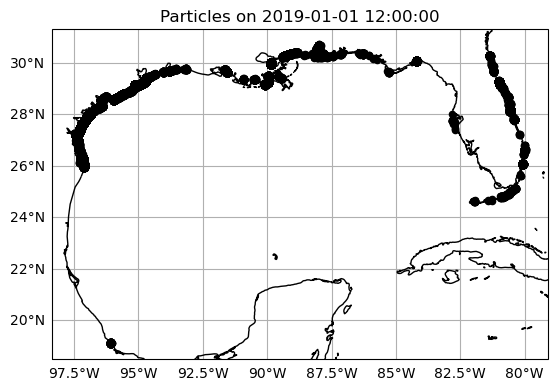

In [2]:
pset.show()

In [7]:


npart = 10
time = np.arange(0, npart) * delta(hours=1).total_seconds()
time

array([    0.,  3600.,  7200., 10800., 14400., 18000., 21600., 25200.,
       28800., 32400.])